In [67]:
# Import TF and check for GPU

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)

# Import required libraries

import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import save_model, load_model
import math
from sklearn.model_selection import train_test_split
import sys

# 1. Load Dataset
## Load Train Set
train_shape_dir = '/home/abraham/Documents/ms_proj_shape_lc_gen/data_npy/shape_npy/shape_filled5.npy'
train_lc_dir = '/home/abraham/Documents/ms_proj_shape_lc_gen/data_npy/lc_npy/lc_dict_5.npy'
train_lc = np.load(train_lc_dir)
train_shape = np.load(train_shape_dir)
# Check equality of number of dataset
if len(train_lc)==len(train_shape):
    print("Train Set: No. of LC = No. of shapes")
else:
    sys.exit("EXIT: Train Set: No. of LC != No. of shapes")

## Load Validation Set
vald_shape_dir = '/home/abraham/Documents/ms_proj_shape_lc_gen/data_npy/shape_npy/shape_filled4.npy'
vald_lc_dir = '/home/abraham/Documents/ms_proj_shape_lc_gen/data_npy/lc_npy/lc_dict_4.npy'
vald_lc = np.load(vald_lc_dir)
vald_shape = np.load(vald_shape_dir)
# Check equality of number of dataset
if len(vald_lc)==len(vald_shape):
    print("Vald Set: No. of LC = No. of shapes")
else:
    sys.exit("Vald Set: No. of LC = No. of shapes")

# 2. Normalize the image, convert to opacity map
## Train Set
train_shape = train_shape/np.amax(train_shape)
train_shape_where_0 = np.where(train_shape == 0)
train_shape_where_1 = np.where(train_shape == 1)
train_shape[train_shape_where_0] = 1  # 1 represent the shape (1 opacity)
train_shape[train_shape_where_1] = 0  # 0 represent background (0 opacity)

## Valdn Set
vald_shape = vald_shape/np.amax(vald_shape)
vald_shape_where_0 = np.where(vald_shape == 0)
vald_shape_where_1 = np.where(vald_shape == 1)
vald_shape[vald_shape_where_0] = 1  # 1 represent the shape (1 opacity)
vald_shape[vald_shape_where_1] = 0  # 0 represent background (0 opacity)

# 2. Normalize the lightcurves
## - Train Set
train_lc_scaled = np.zeros(train_lc.shape)
for i in np.arange(len(train_lc_scaled)):
    train_lc_scaled[i] = (train_lc[i] - np.amin(train_lc[i]))/(np.amax(train_lc[i]) - np.amin(train_lc[i]))

## - Vald Set
vald_lc_scaled = np.zeros(vald_lc.shape)
for i in np.arange(len(vald_lc_scaled)):
    vald_lc_scaled[i] = (vald_lc[i] - np.amin(vald_lc[i]))/(np.amax(vald_lc[i]) - np.amin(vald_lc[i]))


# CNN Model
input_shape = np.array(np.shape(train_lc_scaled[0]))
print("np.shape(input_shape) = ",input_shape[0])

output_shape = np.array(np.shape(train_shape[0]))
print("np.shape(input_shape) = ",output_shape[0],output_shape[1])

START = input_shape[0] # 94 #
END = output_shape[0] # 38  # pixel size along one axis
print("Start = ",START)
print("End = ",END)

conv_ip = keras.layers.Input(shape=(START,),name='Input')
x= keras.layers.Reshape((START, 1), input_shape=(START,),name='reshape_1')(conv_ip)
x= keras.layers.BatchNormalization()(x)

x=keras.layers.Conv1D(16,kernel_size=5,strides=1,activation='relu',name='conv16_5', padding='same')(x)
x=keras.layers.Conv1D(16,kernel_size=5,strides=1,activation='relu',name='second_conv16_5', padding='same')(x)
x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_1', padding='same')(x) #400

x=keras.layers.Conv1D(32,kernel_size=5,strides=1,activation='relu',name='first_conv32_5', padding='same')(x)
x=keras.layers.Conv1D(32,kernel_size=5,strides=1,activation='relu',name='second_conv32_5', padding='same')(x)
x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_2', padding='same')(x) #200

x=keras.layers.Conv1D(64,kernel_size=5,strides=1,activation='relu',name='first_conv64_5', padding='same')(x)
x=keras.layers.Conv1D(64,kernel_size=5,strides=1,activation='relu',name='second_conv64_5', padding='same')(x)
x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_3', padding='same')(x) #100

x=keras.layers.Flatten(name='flat_1')(x)

x2=keras.layers.Dense(256,name='dense_layer_5',activation='relu')(x)
x2=keras.layers.Dense(256,name='dense_layer_6',activation='relu')(x2)

x2= keras.layers.Dense(END**2,name='dense_layer_u',activation='relu')(x2)
x2 = keras.layers.Reshape(target_shape=(END, END, 1),name='reshape_2')(x2)

x2=keras.layers.Conv2D(32,kernel_size=(3,3),strides=1,activation='relu',name='second_conv64_52', padding='same')(x2)
x2=keras.layers.Conv2D(32,kernel_size=(3,3),strides=1,activation='relu',name='second_conv64_522', padding='same')(x2)
x2=keras.layers.Conv2D(16,kernel_size=(3,3),strides=1,activation='relu',name='second_conv64_524', padding='same')(x2)
x2=keras.layers.Conv2D(1,kernel_size=3,strides=1,activation='relu',name='second_conv64_53', padding='same')(x2)
conv_op = keras.layers.Reshape(target_shape=(END, END),name='reshape_3')(x2)
model = keras.Model(inputs=conv_ip, outputs=conv_op, name="predict_shape_from_LC")
model.summary()

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='mse')

#Patience early stopping
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

#Learning rate scheduler
def step_decay(epoch):
	initial_lrate = 0.001
	drop = 0.5
	epochs_drop = 20
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate
lr_sched = keras.callbacks.LearningRateScheduler(step_decay)

# Training 
history = model.fit(train_lc_scaled, train_shape, epochs=2,verbose=2, validation_data=(vald_lc_scaled,vald_shape),callbacks=[es,lr_sched])

# Save Model
save_model(model, "ml_saved_models/model_sep7/model_sep7_v1_no_noise_lc.h5")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.12.1
Train Set: No. of LC = No. of shapes
Vald Set: No. of LC = No. of shapes
np.shape(input_shape) =  100
np.shape(input_shape) =  38 38
Start =  100
End =  38
Model: "predict_shape_from_LC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 100)]             0         
                                                                 
 reshape_1 (Reshape)         (None, 100, 1)            0         
                                                                 
 batch_normalization_1 (Batc  (None, 100, 1)           4         
 hNormalization)                                                 
                                                                 
 conv16_5 (Conv1D)           (None, 100, 16)           96        
                                                           

In [68]:
yPredictonVald = model.predict(vald_lc_scaled)
# vald_shape

32/32 [==============================] - 0s 5ms/step


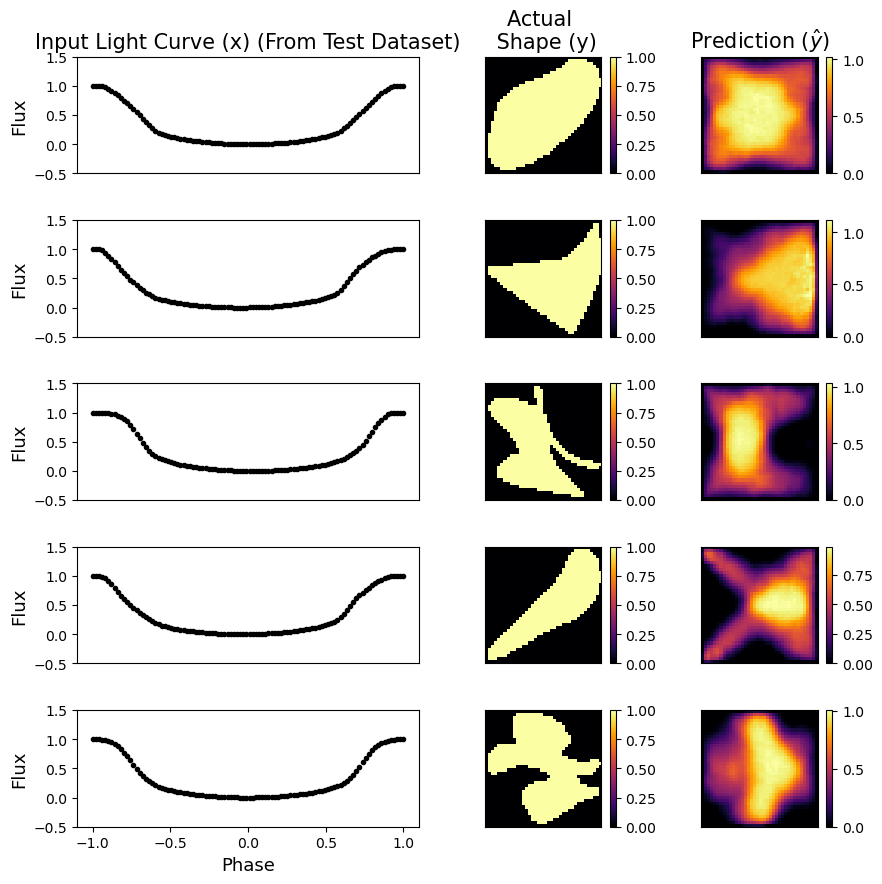

In [70]:
# Test dataset
import random 
num = 5
fig,ax=plt.subplots(num,3, figsize=(10,10), gridspec_kw={ 'width_ratios': [2,1,1],
        'wspace': 0.2,'hspace': 0.4})

ax[0][1].set_title('Actual \n Shape (y)',size=15)
ax[0][0].set_title('Input Light Curve (x) (From Test Dataset)',size=15)
ax[0][2].set_title(r'Prediction ($\hat{y}$)',size=15)
ax[num-1][0].set_xlabel('Phase',size=13)
ph = np.linspace(-1.0,1.0,len(vald_lc_scaled[0]))
# advance = 60
for i in range(num):
    k = random.randint(0, len(vald_lc_scaled)-1)
    ax[i][2].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(vald_shape[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=13)
    ax[i][0].set_ylim(-0.5,1.5)
    ax[i][0].scatter(ph, vald_lc_scaled[k],color = 'black',marker='.')
    img = ax[i][2].imshow(yPredictonVald[k],cmap='inferno')
    plt.colorbar(img)

In [2]:
# to Check whethe mirror images produces flip in light curves
# Import required libraries

import matplotlib.pyplot as plt
import numpy as np


# 1. Load Dataset
## Load Train Set
train_shape_dir = '/home/abraham/Documents/ms_proj_shape_lc_gen/data_npy/shape_npy/shape_filled5.npy'
train_lc_dir = '/home/abraham/Documents/ms_proj_shape_lc_gen/data_npy/lc_npy/lc_dict_5.npy'
train_lc = np.load(train_lc_dir)
train_shape = np.load(train_shape_dir)
# Check equality of number of dataset
if len(train_lc)==len(train_shape):
    print("Train Set: No. of LC = No. of shapes")
else:
    sys.exit("EXIT: Train Set: No. of LC != No. of shapes")

# 2. Normalize the lightcurves
## - Train Set
train_lc_scaled = np.zeros(train_lc.shape)
for i in np.arange(len(train_lc_scaled)):
    train_lc_scaled[i] = (train_lc[i] - np.amin(train_lc[i]))/(np.amax(train_lc[i]) - np.amin(train_lc[i]))


Train Set: No. of LC = No. of shapes


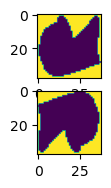

In [62]:
flip_el = 290
el = flip_el + int(132136/2)

plt.subplot(511)
plt.imshow(train_shape[flip_el])

plt.subplot(512)
advance = int(132136/4) #16157 # 66068
plt.imshow(train_shape[el+advance])

# plt.subplot(513)
# el = el + advance
# advance = int(132136/8) #16157 # 66068
# plt.imshow(train_shape[advance+el])

# plt.subplot(514)
# advance = int(132136/2) #16157 # 66068
# plt.imshow(train_shape[advance+el])

# plt.subplot(515)
# advance = int(132136/2) #16157 # 66068
# plt.imshow(train_shape[advance+el])
plt.show()
# print(train_shape[el][0])
# print(train_shape[advance+el][-1])

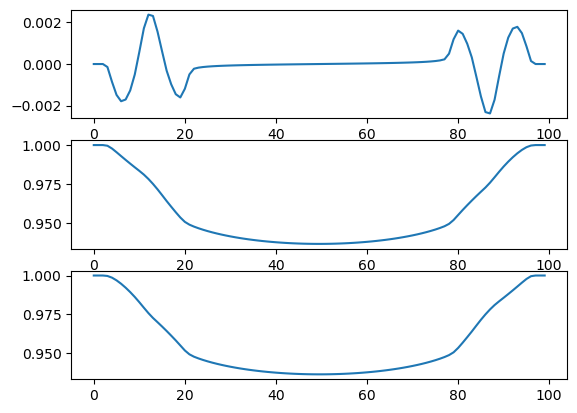

In [63]:
plt.subplot(311)
plt.plot(np.arange(len(train_lc_scaled[el])),train_lc[flip_el]-train_lc[el+advance])

plt.subplot(312)
plt.plot(np.arange(len(train_lc_scaled[el])),train_lc[flip_el])

plt.subplot(313)
plt.plot(np.arange(len(train_lc_scaled[el])),train_lc[el+advance])

plt.show()

# Old

In [1]:
import tensorflow as tf

2023-09-04 11:32:57.727326: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-04 11:32:58.723494: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/abraham/miniconda3/envs/tf/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print(tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.12.1


In [3]:
# Import required libraries

import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from keras import layers
import random
from tensorflow.keras.models import save_model, load_model
import math
from sklearn.model_selection import train_test_split


In [5]:
xTrain_dir  = '../ms_proj_shape_lc_gen/data_npy/lc_npy/lc_dict_3.npy'
xTrain = np.load(xTrain_dir)
# xTrain = xTrain/np.amax(xTrain)
yTrain_dir = '../ms_proj_shape_lc_gen/data_npy/shape_npy/shape_filled3.npy'
# y_dir  = '../ms_proj_shape_lc_gen/data_npy/shape_concat_npy/shape_concat1.npy'
yTrain = np.load(yTrain_dir)
print('np.amax(yTrain) = ',np.amax(yTrain))
print('len(yTrain) = ',len(yTrain))
print('len(xTrain) = ',len(xTrain))

# Normalizing the image of the shape
yTrain = yTrain/255.0
print('np.amax(yTrain) after dividing by 255 = ',np.amax(yTrain))
where_0 = np.where(yTrain == 0)
where_1 = np.where(yTrain == 1)
yTrain[where_0] = 1  # 1 represent the shape - opacity = 1
yTrain[where_1] = 0  # 0 represent background - opacity = 0

# Test Set

xTest_dir  = '../ms_proj_shape_lc_gen/data_npy/lc_npy/lc_dict_4.npy'
xTest = np.load(xTest_dir)
xTest = xTest/np.amax(xTest)
yTest_dir = '../ms_proj_shape_lc_gen/data_npy/shape_npy/shape_filled4.npy'
# y_dir  = '../ms_proj_shape_lc_gen/data_npy/shape_concat_npy/shape_concat1.npy'
yTest = np.load(yTest_dir)
print('np.amax(Test) = ',np.amax(yTest))
print('len(yTest) = ',len(yTest))
print('len(xTest) = ',len(xTest))

# Normalizing the image of the shape
yTest = yTest/255.0
print('np.amax(yTest) after dividing by 255 = ',np.amax(yTest))

where_0 = np.where(yTest == 0)
where_1 = np.where(yTest == 1)
yTest[where_0] = 1  # 1 represent the shape
yTest[where_1] = 0  # 0 represent background

np.amax(yTrain) =  255.0
len(yTrain) =  15465
len(xTrain) =  15465
np.amax(yTrain) after dividing by 255 =  1.0
np.amax(Test) =  255.0
len(yTest) =  1000
len(xTest) =  1000
np.amax(yTest) after dividing by 255 =  1.0


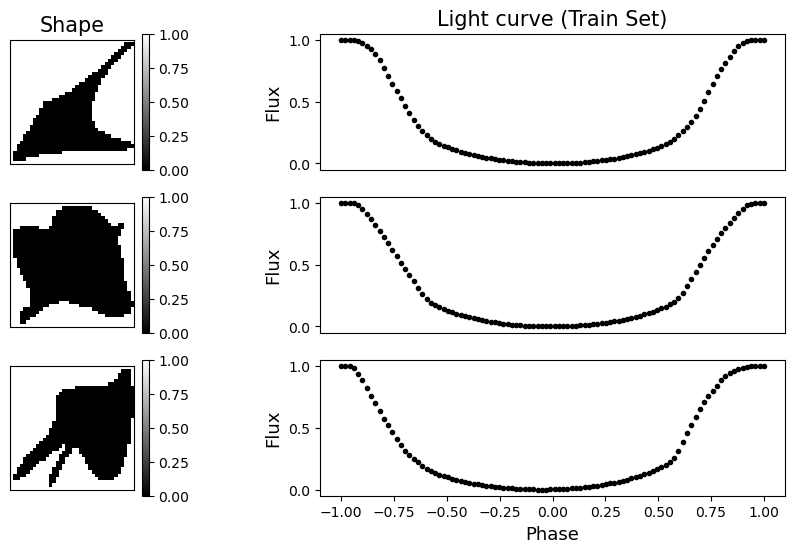

In [6]:
# Normalize light curve 
# - Train

xTrain_scaled = np.zeros(xTrain.shape)
for i in np.arange(len(xTrain_scaled)):
    # x_scaled[i] = x[i] / np.linalg.norm(x[i])
    xTrain_scaled[i] = (xTrain[i] - np.amin(xTrain[i]))/(np.amax(xTrain[i]) - np.amin(xTrain[i]))
# - Test
xTest_scaled = np.zeros(xTest.shape)
for i in np.arange(len(xTest_scaled)):
    # x_scaled[i] = x[i] / np.linalg.norm(x[i])
    xTest_scaled[i] = (xTest[i] - np.amin(xTest[i]))/(np.amax(xTest[i]) - np.amin(xTest[i]))

# - or
# x_scaled = x
# -
# Plot some Train Set sample
np.random.seed(123)

num = 3
fig,ax=plt.subplots(num,2, figsize=(10,6), gridspec_kw={ 'width_ratios': [1,3],
        'wspace': 0.5,'hspace': 0.2})

ax[0][0].set_title('Shape',size=15)
ax[0][1].set_title('Light curve (Train Set)',size=15)
ax[num-1][1].set_xlabel('Phase',size=13)
ph = np.linspace(-1.0,1.0,len(xTrain[0]))
for i in range(num):
    k = random.randint(0, len(xTrain_scaled)-1)
    ax[i][0].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][1].tick_params(labelbottom = False, bottom = False)
    img = ax[i][0].imshow(yTrain[k],cmap='gray')
    plt.colorbar(img)
    ax[i][1].set_ylabel('Flux',size=13)
    ax[i][1].scatter(ph, xTrain_scaled[k],color = 'black',marker='.')
    # ax[i][1].set_ylim(0,1)

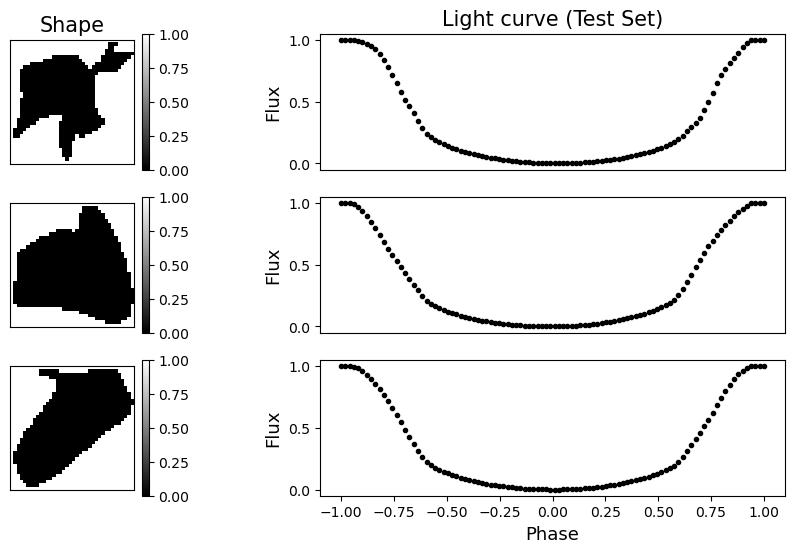

In [7]:
np.random.seed(123)

num = 3
fig,ax=plt.subplots(num,2, figsize=(10,6), gridspec_kw={ 'width_ratios': [1,3],
        'wspace': 0.5,'hspace': 0.2})

ax[0][0].set_title('Shape',size=15)
ax[0][1].set_title('Light curve (Test Set)',size=15)
ax[num-1][1].set_xlabel('Phase',size=13)
ph = np.linspace(-1.0,1.0,len(xTest[0]))
for i in range(num):
    k = random.randint(0, len(xTest_scaled)-1)
    ax[i][0].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][1].tick_params(labelbottom = False, bottom = False)
    img = ax[i][0].imshow(yTest[k],cmap='gray')
    plt.colorbar(img)
    ax[i][1].set_ylabel('Flux',size=13)
    ax[i][1].scatter(ph, xTest_scaled[k],color = 'black',marker='.')
    # ax[i][1].set_ylim(0,1)

In [7]:
# Adding noise

# mu, sigma = 0.004, 0.059
# x_scaled_noise = np.zeros(x_scaled.shape)
# s = np.zeros(x_scaled.shape)
# for i in np.arange(0,int(x_scaled.shape[0]),1):
#     s[i] = np.random.normal(mu, sigma, len(x_scaled[0]))

# x_scaled_noise = x_scaled + s

In [ ]:
# # Plot some sample
# np.random.seed(123)


# num = 3
# fig,ax=plt.subplots(num,3, figsize=(12,8), gridspec_kw={ 'width_ratios': [1,2,2],
#         'wspace': 0.5,'hspace': 0.2})

# ax[0][0].set_title('Shape',size=15)
# ax[0][1].set_title('Light curve without noise',size=15)
# ax[num-1][1].set_xlabel('Phase',size=13)
# ax[0][2].set_title('Light curve after adding noise',size=15)
# ax[num-1][2].set_xlabel('Phase',size=13)
# ph = np.linspace(-1.0,1.0,len(x_scaled[0]))

# for i in range(num):
#     k = random.randint(0, len(x_scaled)-1)

#     ax[i][0].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
#     if(i<num-1): ax[i][1].tick_params(labelbottom = False, bottom = False)
#     img = ax[i][0].imshow(y[k],cmap='inferno')
#     plt.colorbar(img)
#     ax[i][1].set_ylabel('Flux',size=13)
#     ax[i][1].scatter(ph, x_scaled[k],color = 'black',marker='.')
#     ax[i][1].set_ylim(-0.5,1.5)
#     ax[i][1].grid('on')
#     ax[i][2].scatter(ph, x_scaled_noise[k],color = 'black',marker='.')
#     ax[i][2].set_ylim(-0.5,1.5)
#     ax[i][2].grid('on')

In [8]:
# Splitting dataset into Train and Test (80 - 20)

# x_ML = x_scaled # x_scaled_noise # x
# y_ML = y

# xTrain, xTest, yTrain, yTest = train_test_split(x_ML, y_ML, test_size=0.01, random_state=5)

print(xTrain_scaled.shape, xTest_scaled.shape, yTrain.shape, yTest.shape)

(15465, 100) (1000, 100) (15465, 38, 38) (1000, 38, 38)


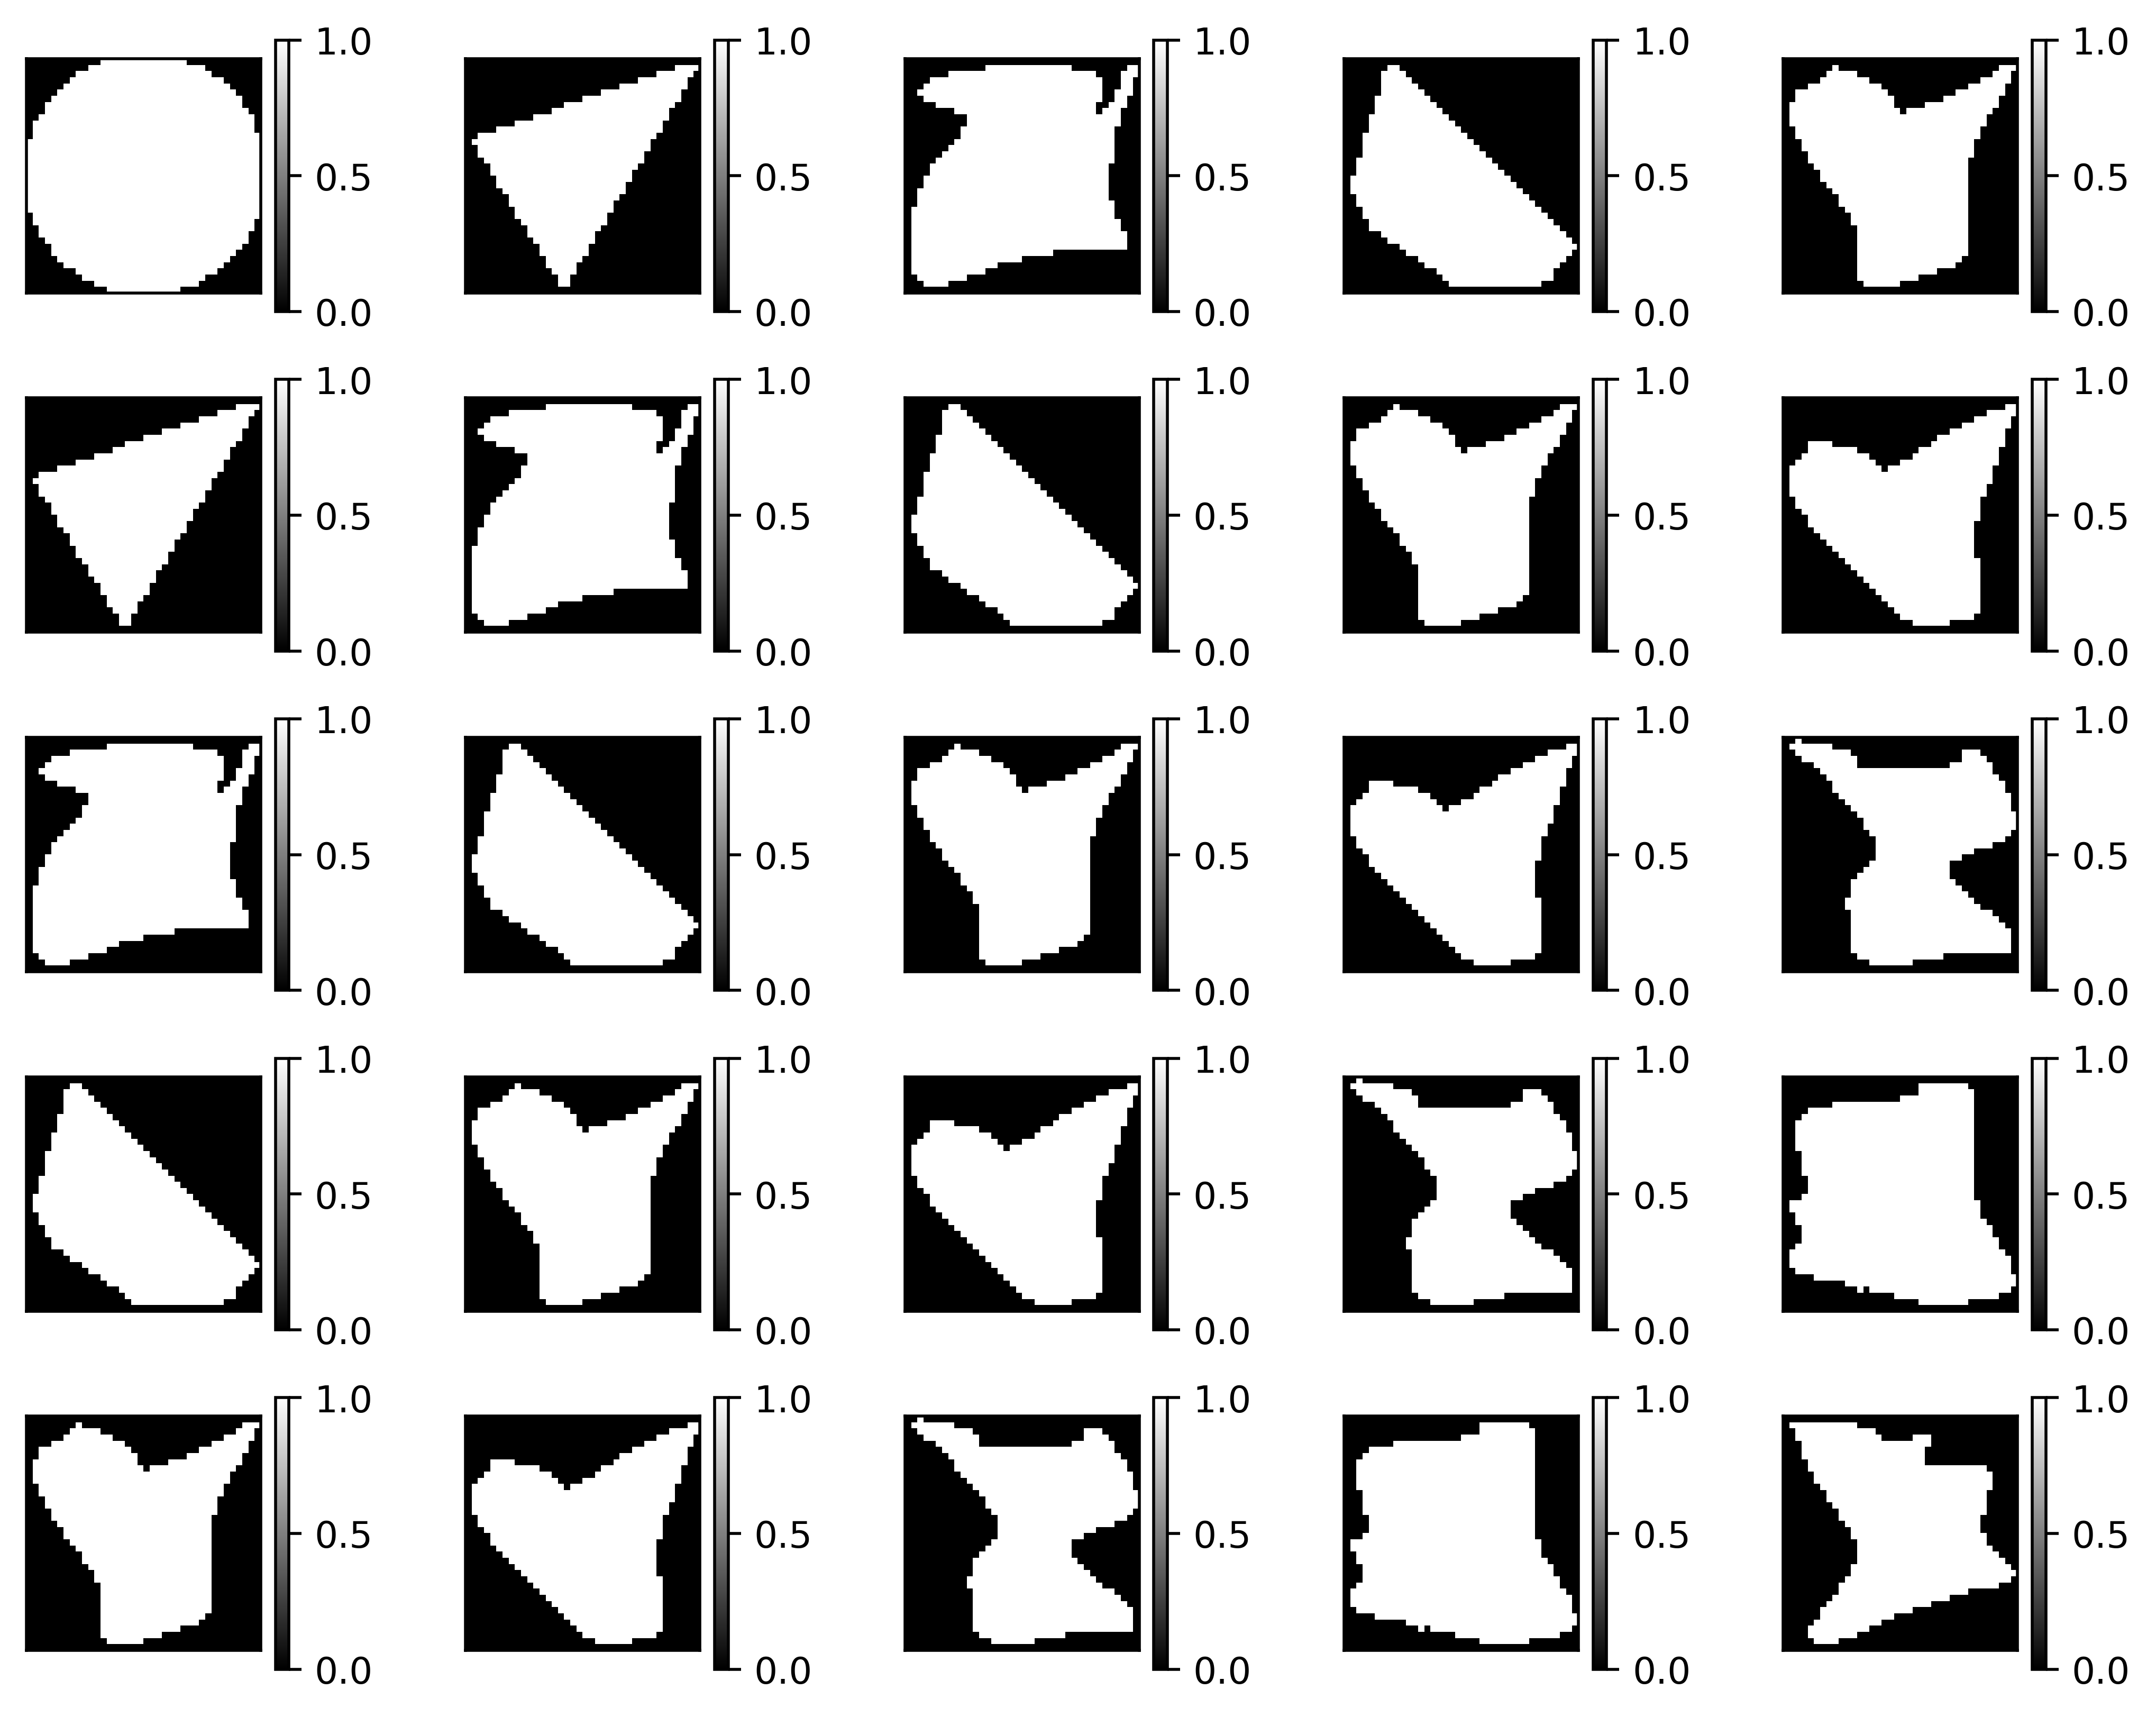

In [9]:
# Plot 5 x 5 shapes -= Train Set
plt.rcParams.update({'figure.dpi': '500'})

num = 5
fig,ax=plt.subplots(num,5, figsize=(10,8), gridspec_kw={ 'width_ratios': [1,1,1,1,1],
        'wspace': 0.5,'hspace': 0.25})


for i in range(num):
    k = i # random.randint(3, len(x)-1)
    rand_t = np.arange(1,6,1)
    for j in range(5):
        t = j + 100 # rand_t[j]
        ax[i][j].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
        # img = ax[i][j].imshow(y[k+t],cmap='inferno')
        img = ax[i][j].imshow(yTrain[k+t],cmap='gray')
        plt.colorbar(img)
        # ax[i][1].imshow(y[k+1],cmap='inferno')
        # ax[i][2].imshow(y[k+2],cmap='inferno')
        # ax[i][3].imshow(y[k+3],cmap='inferno')
        # ax[i][4].imshow(y[k+4],cmap='inferno')

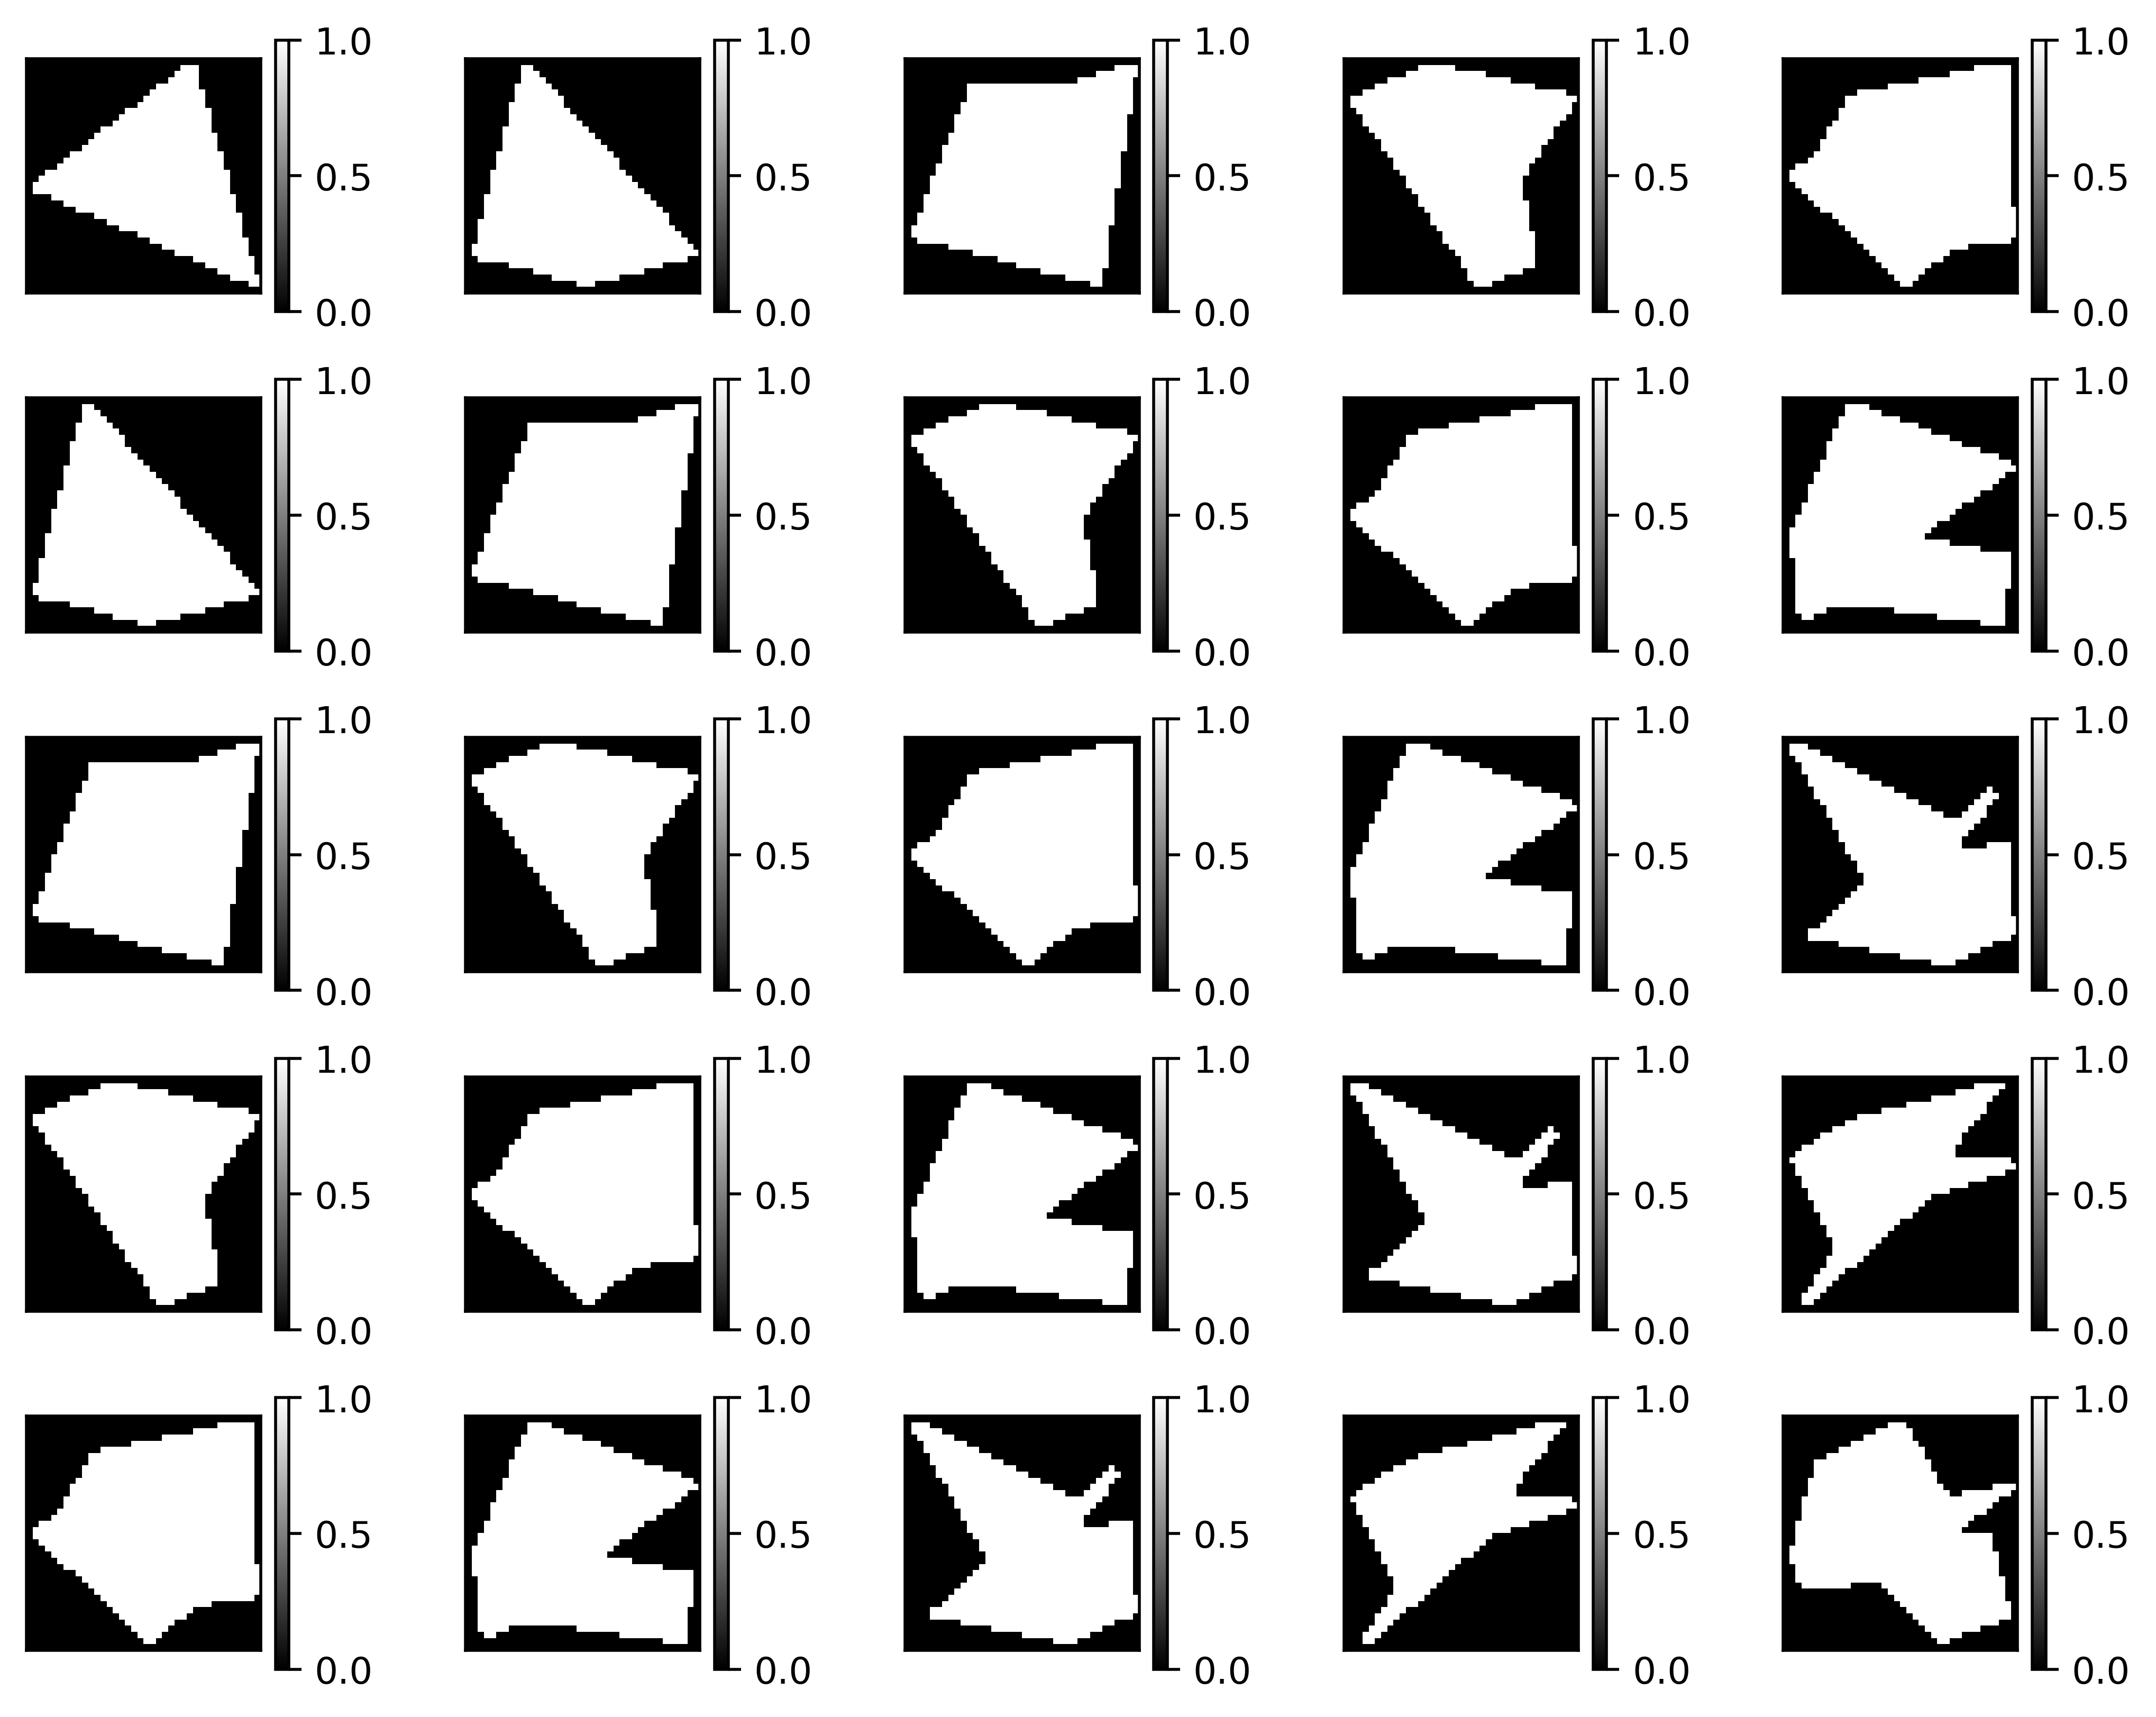

In [10]:
# Plot 5 x 5 shapes - Test Set
plt.rcParams.update({'figure.dpi': '500'})

num = 5
fig,ax=plt.subplots(num,5, figsize=(10,8), gridspec_kw={ 'width_ratios': [1,1,1,1,1],
        'wspace': 0.5,'hspace': 0.25})


for i in range(num):
    k = i # random.randint(3, len(x)-1)
    rand_t = np.arange(1,6,1)
    for j in range(5):
        t = j # rand_t[j]
        ax[i][j].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
        # img = ax[i][j].imshow(y[k+t],cmap='inferno')
        img = ax[i][j].imshow(yTest[k+t],cmap='gray')
        plt.colorbar(img)
        # ax[i][1].imshow(y[k+1],cmap='inferno')
        # ax[i][2].imshow(y[k+2],cmap='inferno')
        # ax[i][3].imshow(y[k+3],cmap='inferno')
        # ax[i][4].imshow(y[k+4],cmap='inferno')

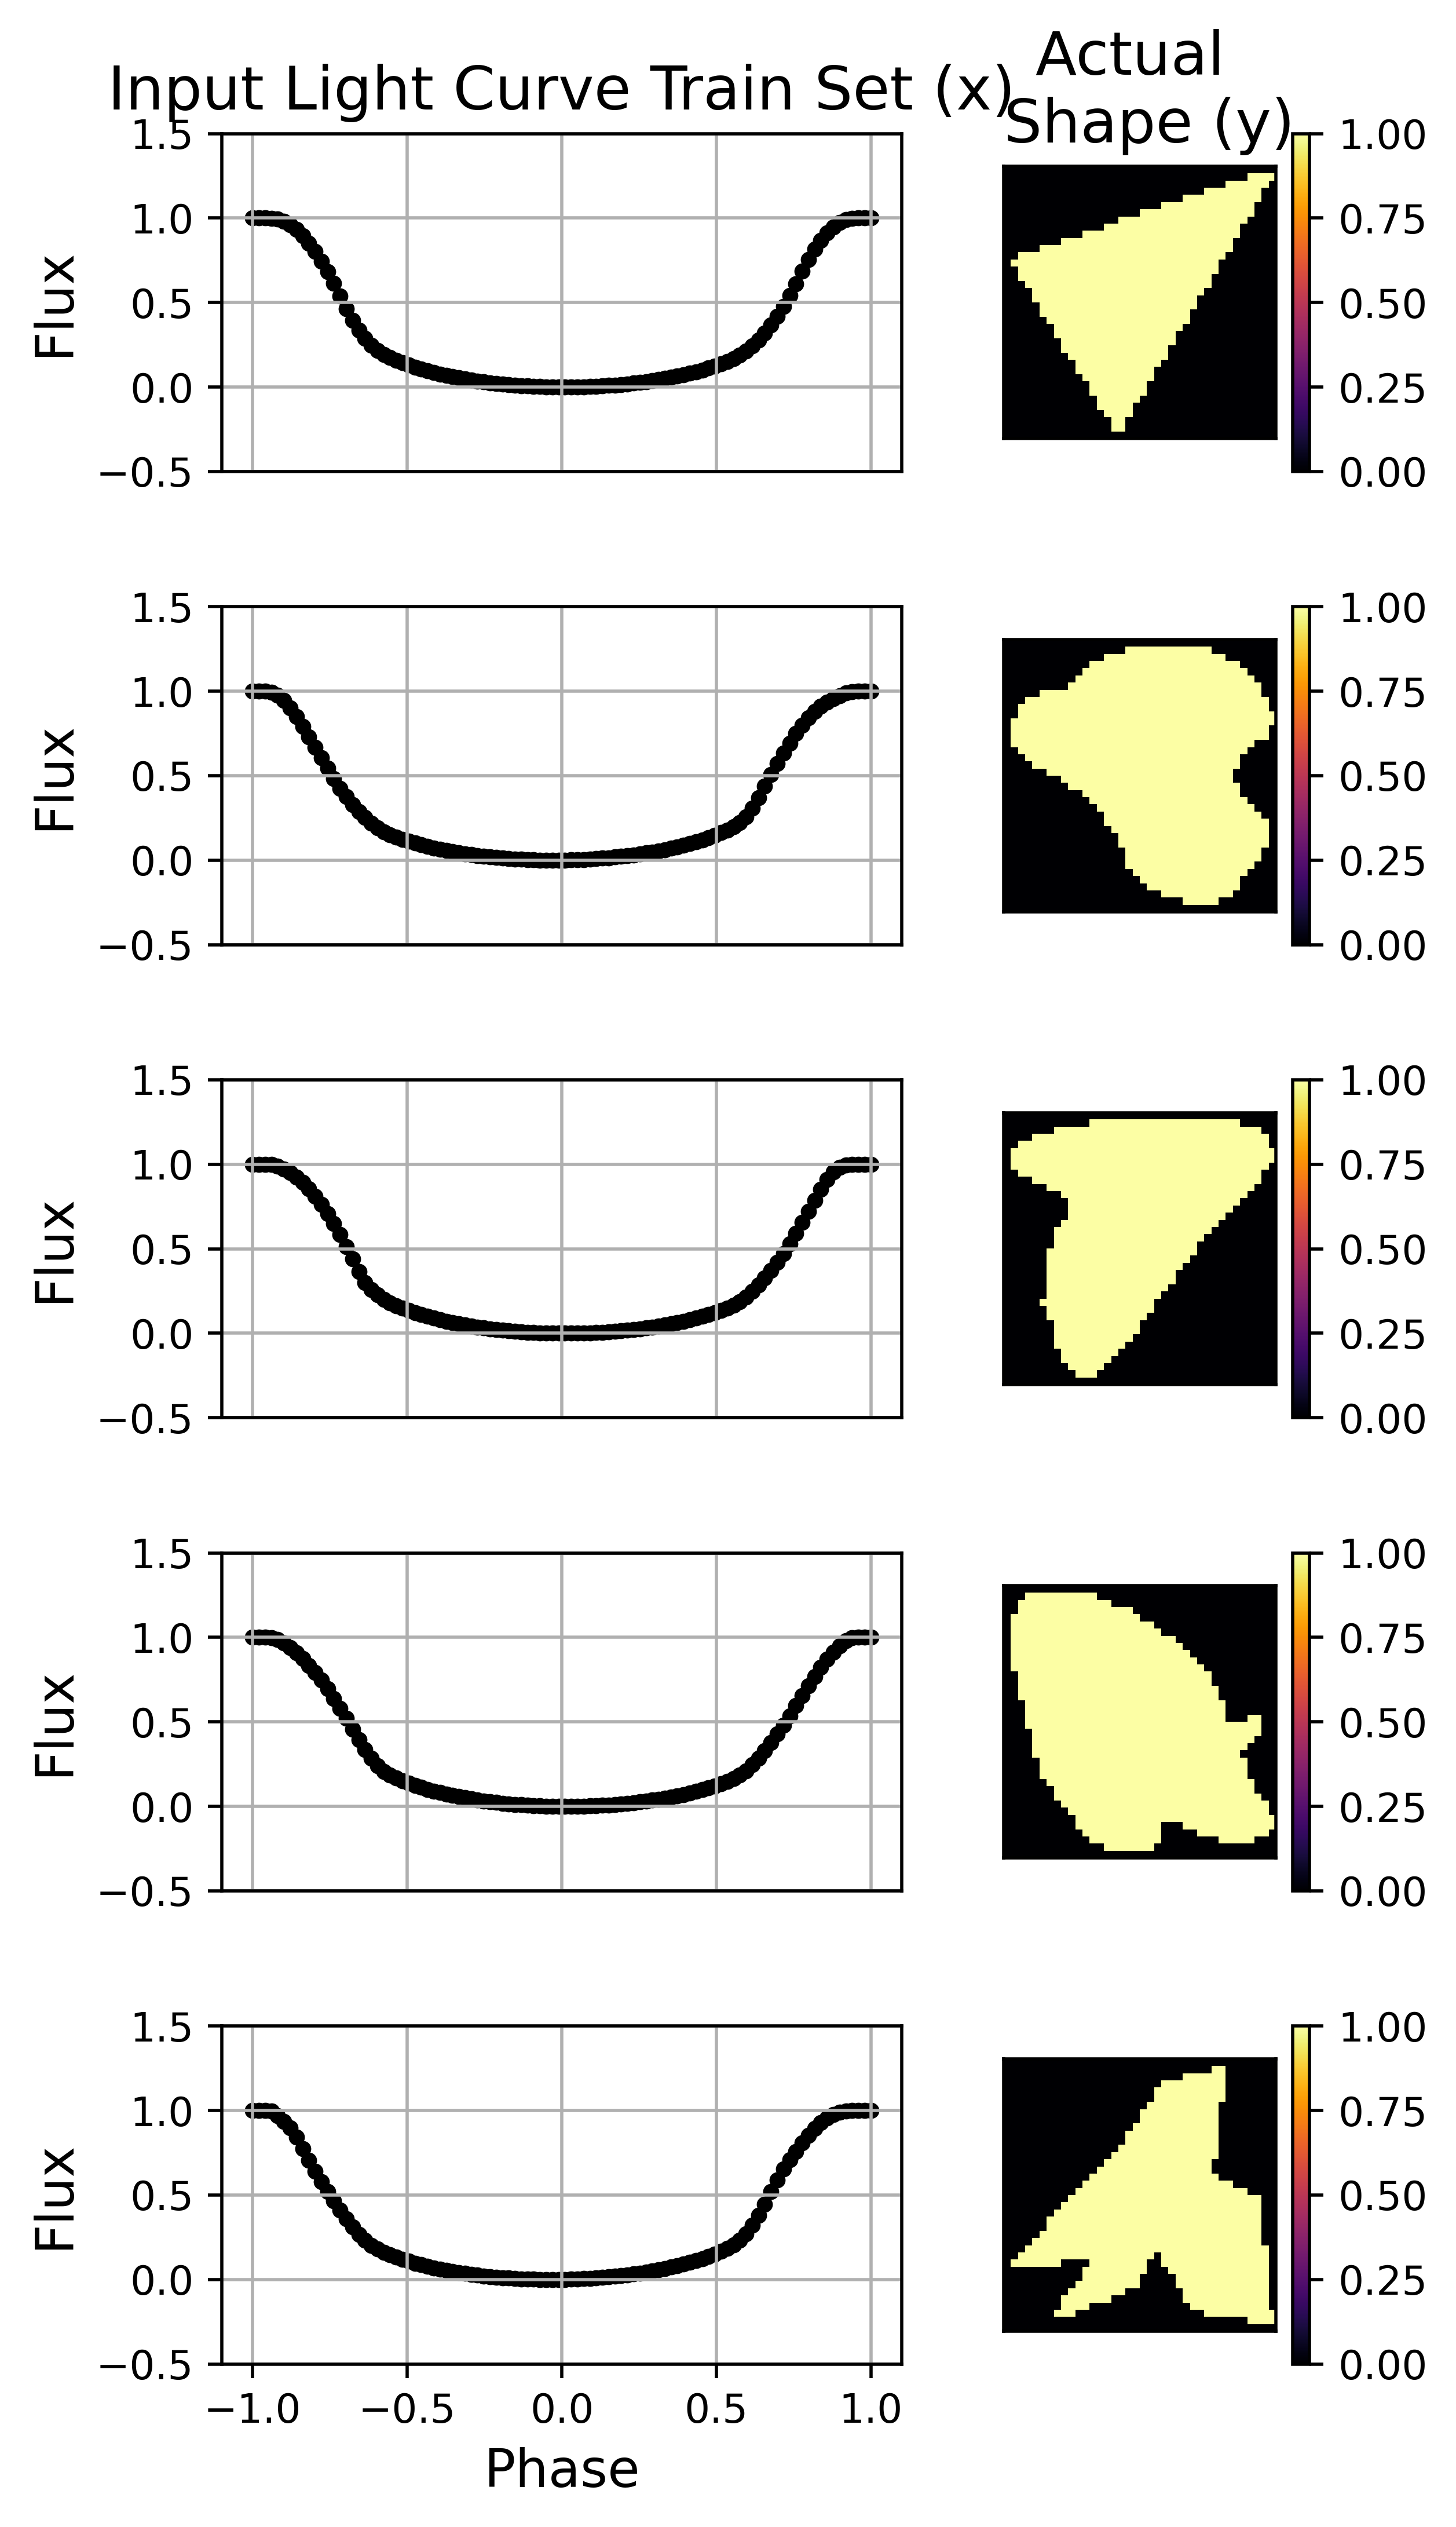

In [11]:
num = 5
fig,ax=plt.subplots(num,2, figsize=(5,10), gridspec_kw={ 'width_ratios': [2,1],
        'wspace': 0.2,'hspace': 0.4})

ax[0][1].set_title('Actual \n Shape (y)',size=15)
ax[0][0].set_title('Input Light Curve Train Set (x)',size=15)
ax[num-1][0].set_xlabel('Phase',size=13)
ph = np.linspace(-1,1,len(xTrain[0]))
# advance = 60
num_array = [1,1001,2001,3001,4001]

i = 0
for i in np.arange(0,len(num_array)):
    k = num_array[i]
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(yTrain[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=13)
    ax[i][0].set_ylim(-0.5,1.5)
    ax[i][0].scatter(ph, xTrain_scaled[k],color = 'black',marker='.')
    ax[i][0].grid('on')
    i = i + 1

In [12]:
# Deep learning model (same as that used by Ushasi)
input_shape = np.array(np.shape(xTrain_scaled[0]))
print("np.shape(input_shape) = ",input_shape[0])

output_shape = np.array(np.shape(yTrain[0]))
print("np.shape(input_shape) = ",output_shape[0],output_shape[1])

START = input_shape[0] # 94 #
END = output_shape[0] # 38  # pixel size along one axis
print("Start = ",START)
print("End = ",END)

conv_ip = keras.layers.Input(shape=(START,),name='Input')
x= keras.layers.Reshape((START, 1), input_shape=(START,),name='reshape_1')(conv_ip)
x= keras.layers.BatchNormalization()(x)

x=keras.layers.Conv1D(16,kernel_size=5,strides=1,activation='relu',name='conv16_5', padding='same')(x)
x=keras.layers.Conv1D(16,kernel_size=5,strides=1,activation='relu',name='second_conv16_5', padding='same')(x)
x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_1', padding='same')(x) #400

x=keras.layers.Conv1D(32,kernel_size=5,strides=1,activation='relu',name='first_conv32_5', padding='same')(x)
x=keras.layers.Conv1D(32,kernel_size=5,strides=1,activation='relu',name='second_conv32_5', padding='same')(x)
x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_2', padding='same')(x) #200

x=keras.layers.Conv1D(64,kernel_size=5,strides=1,activation='relu',name='first_conv64_5', padding='same')(x)
x=keras.layers.Conv1D(64,kernel_size=5,strides=1,activation='relu',name='second_conv64_5', padding='same')(x)
x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_3', padding='same')(x) #100

# x=keras.layers.Conv1D(128,kernel_size=5,strides=1,activation='relu',name='first_conv128_5', padding='same')(x)
# x=keras.layers.Conv1D(128,kernel_size=5,strides=1,activation='relu',name='second_conv128_5', padding='same')(x)
# x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_4', padding='same')(x) #100

# x=keras.layers.Conv1D(256,kernel_size=5,strides=1,activation='relu',name='first_conv256_5', padding='same')(x)
# x=keras.layers.Conv1D(256,kernel_size=5,strides=1,activation='relu',name='second_conv256_5', padding='same')(x)
# x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_5', padding='same')(x) #100


x=keras.layers.Flatten(name='flat_1')(x)

# x2=keras.layers.Dense(512,name='dense_layer_1',activation='relu')(x)
# x2=keras.layers.Dense(512,name='dense_layer_2',activation='relu')(x2)
# x2=keras.layers.Dense(512,name='dense_layer_3',activation='relu')(x2)
# x2=keras.layers.Dense(512,name='dense_layer_4',activation='relu')(x2)

x2=keras.layers.Dense(256,name='dense_layer_5',activation='relu')(x)
x2=keras.layers.Dense(256,name='dense_layer_6',activation='relu')(x2)
# x2=keras.layers.Dense(256,name='dense_layer_7',activation='relu')(x2)
# x2=keras.layers.Dense(256,name='dense_layer_8',activation='relu')(x2)

x2= keras.layers.Dense(END**2,name='dense_layer_u',activation='relu')(x2)
x2 = keras.layers.Reshape(target_shape=(END, END, 1),name='reshape_2')(x2)

x2=keras.layers.Conv2D(32,kernel_size=(3,3),strides=1,activation='relu',name='second_conv64_52', padding='same')(x2)
x2=keras.layers.Conv2D(32,kernel_size=(3,3),strides=1,activation='relu',name='second_conv64_522', padding='same')(x2)
x2=keras.layers.Conv2D(16,kernel_size=(3,3),strides=1,activation='relu',name='second_conv64_524', padding='same')(x2)
x2=keras.layers.Conv2D(1,kernel_size=3,strides=1,activation='relu',name='second_conv64_53', padding='same')(x2)
conv_op = keras.layers.Reshape(target_shape=(END, END),name='reshape_3')(x2)
model = keras.Model(inputs=conv_ip, outputs=conv_op, name="predict_shape_from_LC")
model.summary()


np.shape(input_shape) =  100
np.shape(input_shape) =  38 38
Start =  100
End =  38


2023-09-01 19:14:09.239647: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30931 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


Model: "predict_shape_from_LC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 100)]             0         
                                                                 
 reshape_1 (Reshape)         (None, 100, 1)            0         
                                                                 
 batch_normalization (BatchN  (None, 100, 1)           4         
 ormalization)                                                   
                                                                 
 conv16_5 (Conv1D)           (None, 100, 16)           96        
                                                                 
 second_conv16_5 (Conv1D)    (None, 100, 16)           1296      
                                                                 
 maxpool_1 (MaxPooling1D)    (None, 50, 16)            0         
                                             

In [13]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='mse')


In [14]:
#Patience early stopping
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
# es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

#Learning rate scheduler
def step_decay(epoch):
	initial_lrate = 0.001
	drop = 0.5
	epochs_drop = 20
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

lr_sched = keras.callbacks.LearningRateScheduler(step_decay)

In [28]:
# Train the model

history = model.fit(xTrain_scaled, yTrain, epochs=2000,verbose=2, validation_split=0.2,callbacks=[es,lr_sched])

Epoch 1/2000
387/387 - 7s - loss: 0.1302 - val_loss: 0.1207 - lr: 0.0010 - 7s/epoch - 17ms/step
Epoch 2/2000
387/387 - 7s - loss: 0.1221 - val_loss: 0.1177 - lr: 0.0010 - 7s/epoch - 18ms/step
Epoch 3/2000
387/387 - 7s - loss: 0.1203 - val_loss: 0.1165 - lr: 0.0010 - 7s/epoch - 18ms/step
Epoch 4/2000
387/387 - 7s - loss: 0.1189 - val_loss: 0.1176 - lr: 0.0010 - 7s/epoch - 17ms/step
Epoch 5/2000
387/387 - 7s - loss: 0.1189 - val_loss: 0.1158 - lr: 0.0010 - 7s/epoch - 18ms/step
Epoch 6/2000
387/387 - 7s - loss: 0.1180 - val_loss: 0.1185 - lr: 0.0010 - 7s/epoch - 18ms/step
Epoch 7/2000
387/387 - 7s - loss: 0.1173 - val_loss: 0.1142 - lr: 0.0010 - 7s/epoch - 18ms/step
Epoch 8/2000
387/387 - 7s - loss: 0.1165 - val_loss: 0.1145 - lr: 0.0010 - 7s/epoch - 17ms/step
Epoch 9/2000
387/387 - 7s - loss: 0.1162 - val_loss: 0.1156 - lr: 0.0010 - 7s/epoch - 17ms/step
Epoch 10/2000
387/387 - 7s - loss: 0.1155 - val_loss: 0.1128 - lr: 0.0010 - 7s/epoch - 17ms/step
Epoch 11/2000
387/387 - 7s - loss: 0.11

In [29]:
save_model(model, "ml_saved_models/model_sep1/model_sep1_v2_2000epoch_no_noise_lc.h5")

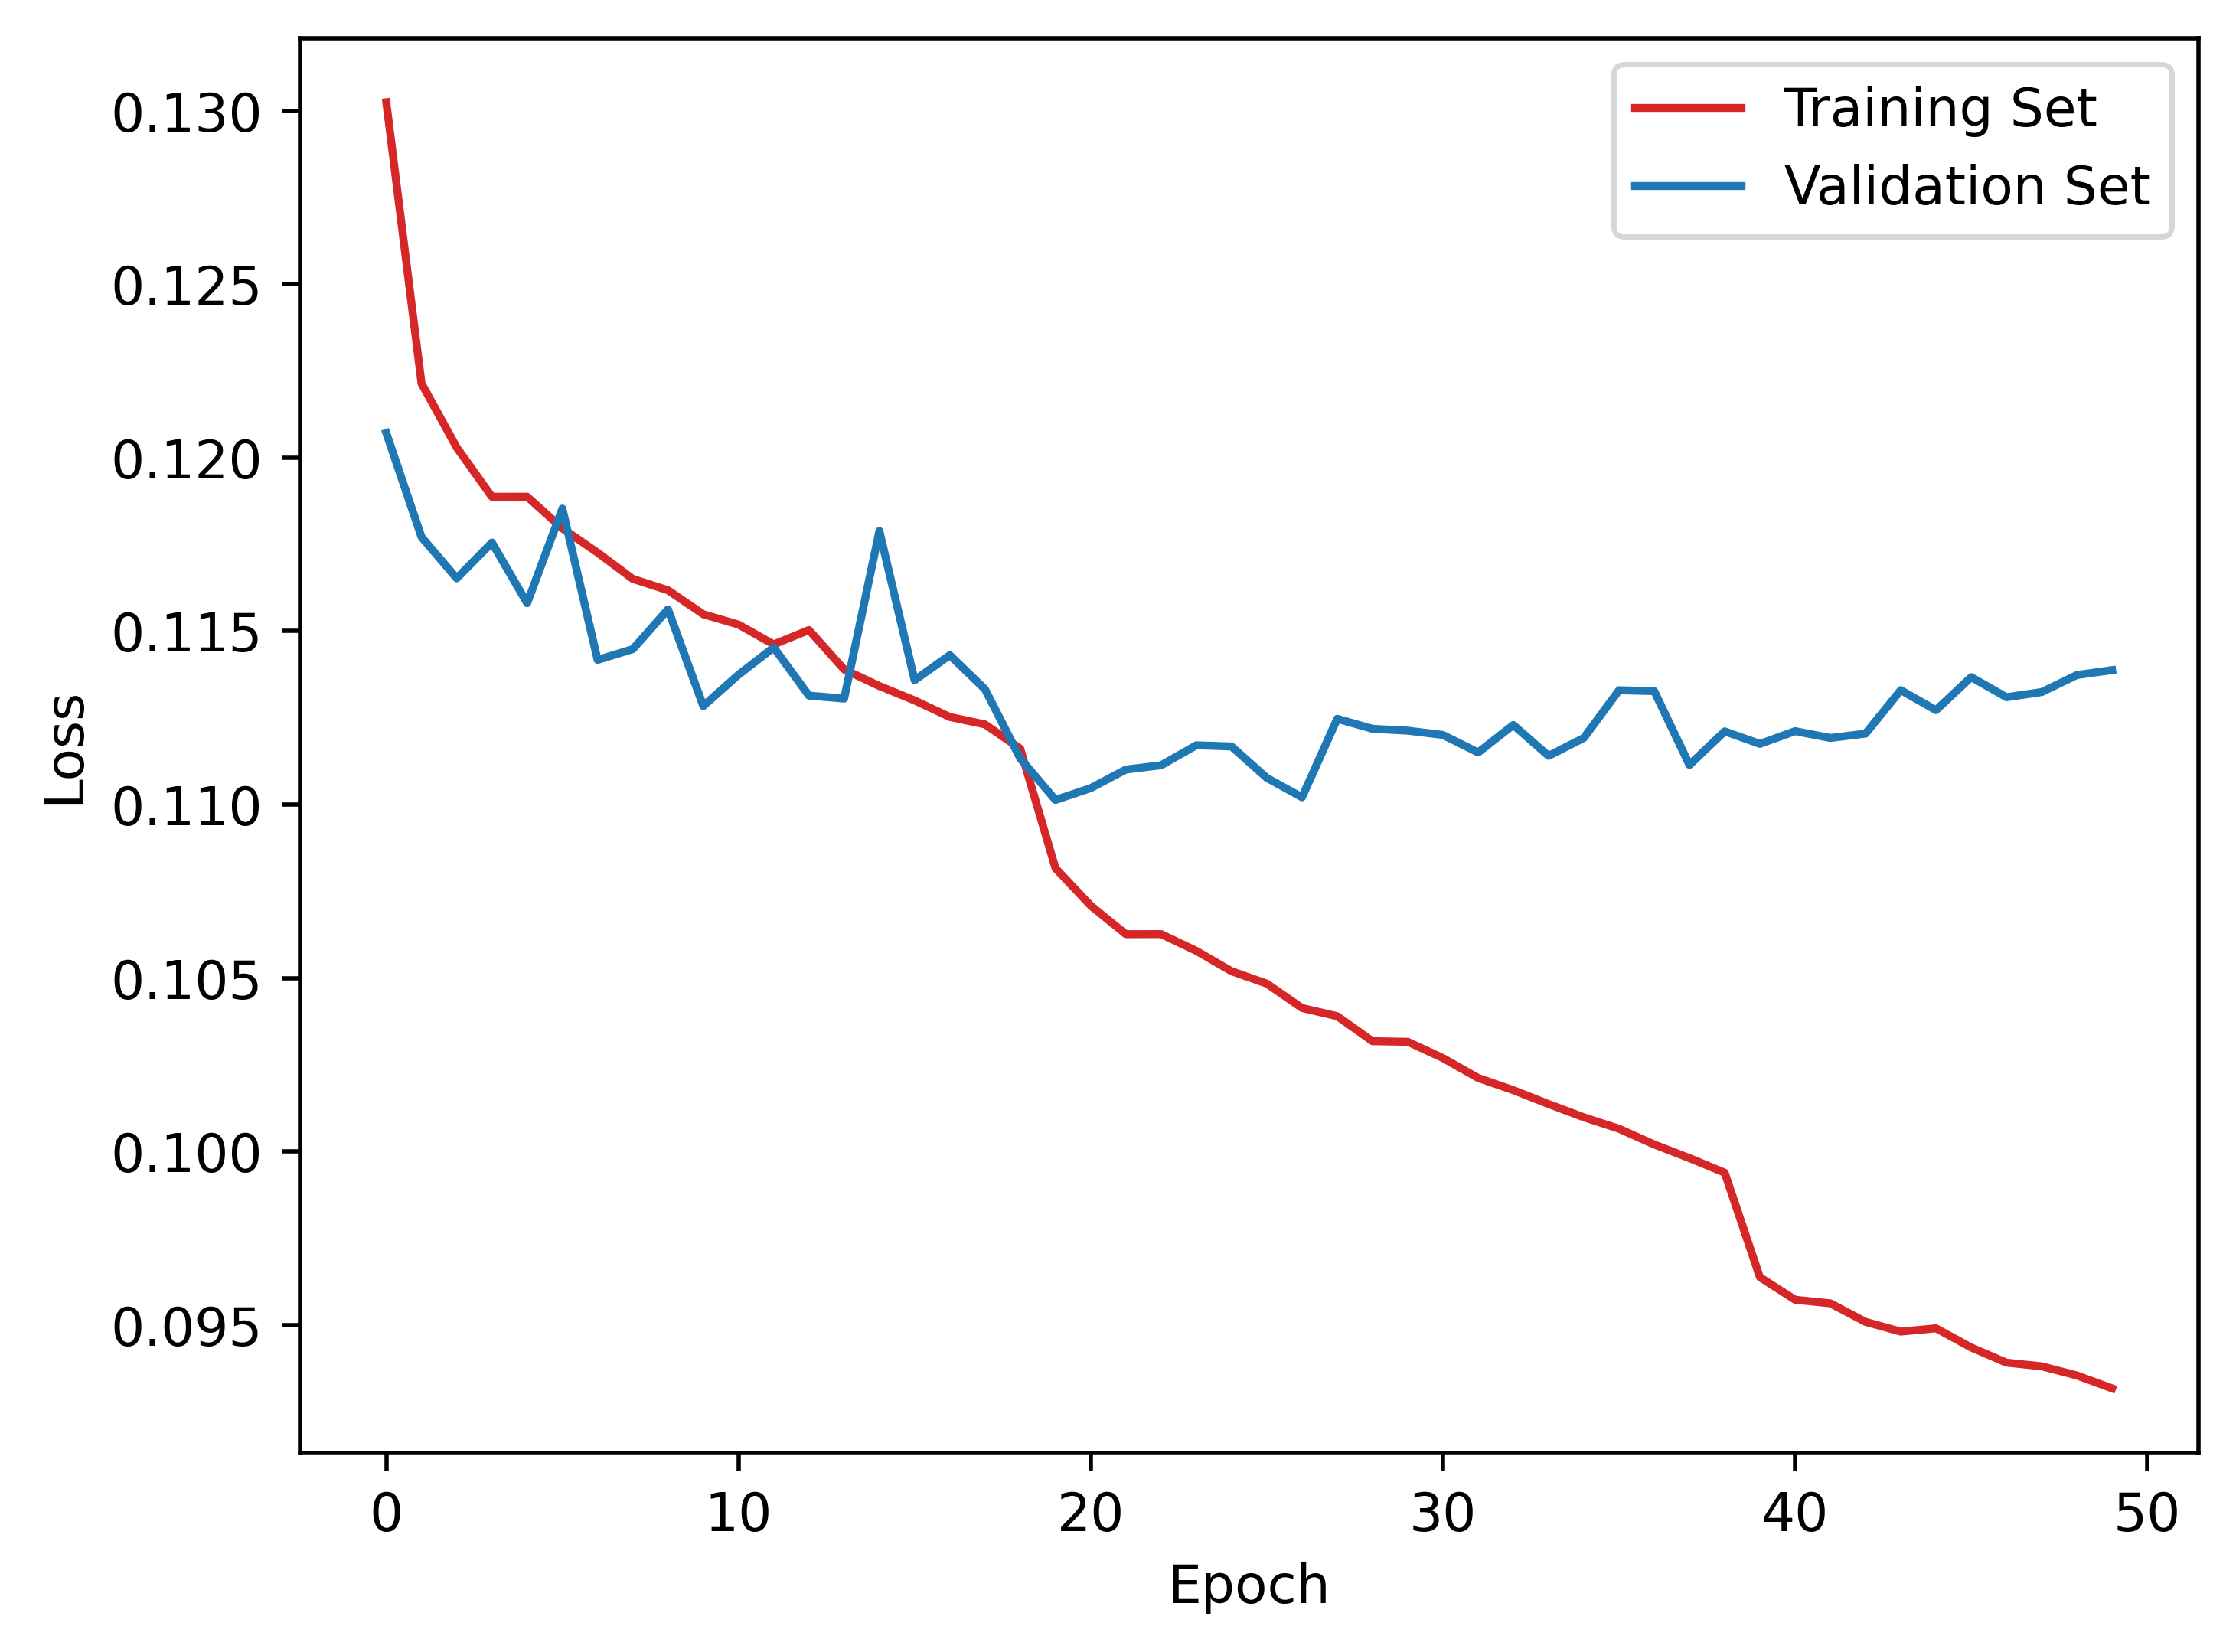

In [30]:
# Plot training parameters
plt.plot(history.history['loss'], label='Training Set',color = "tab:red")
plt.plot(history.history['val_loss'], label='Validation Set',color = "tab:blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

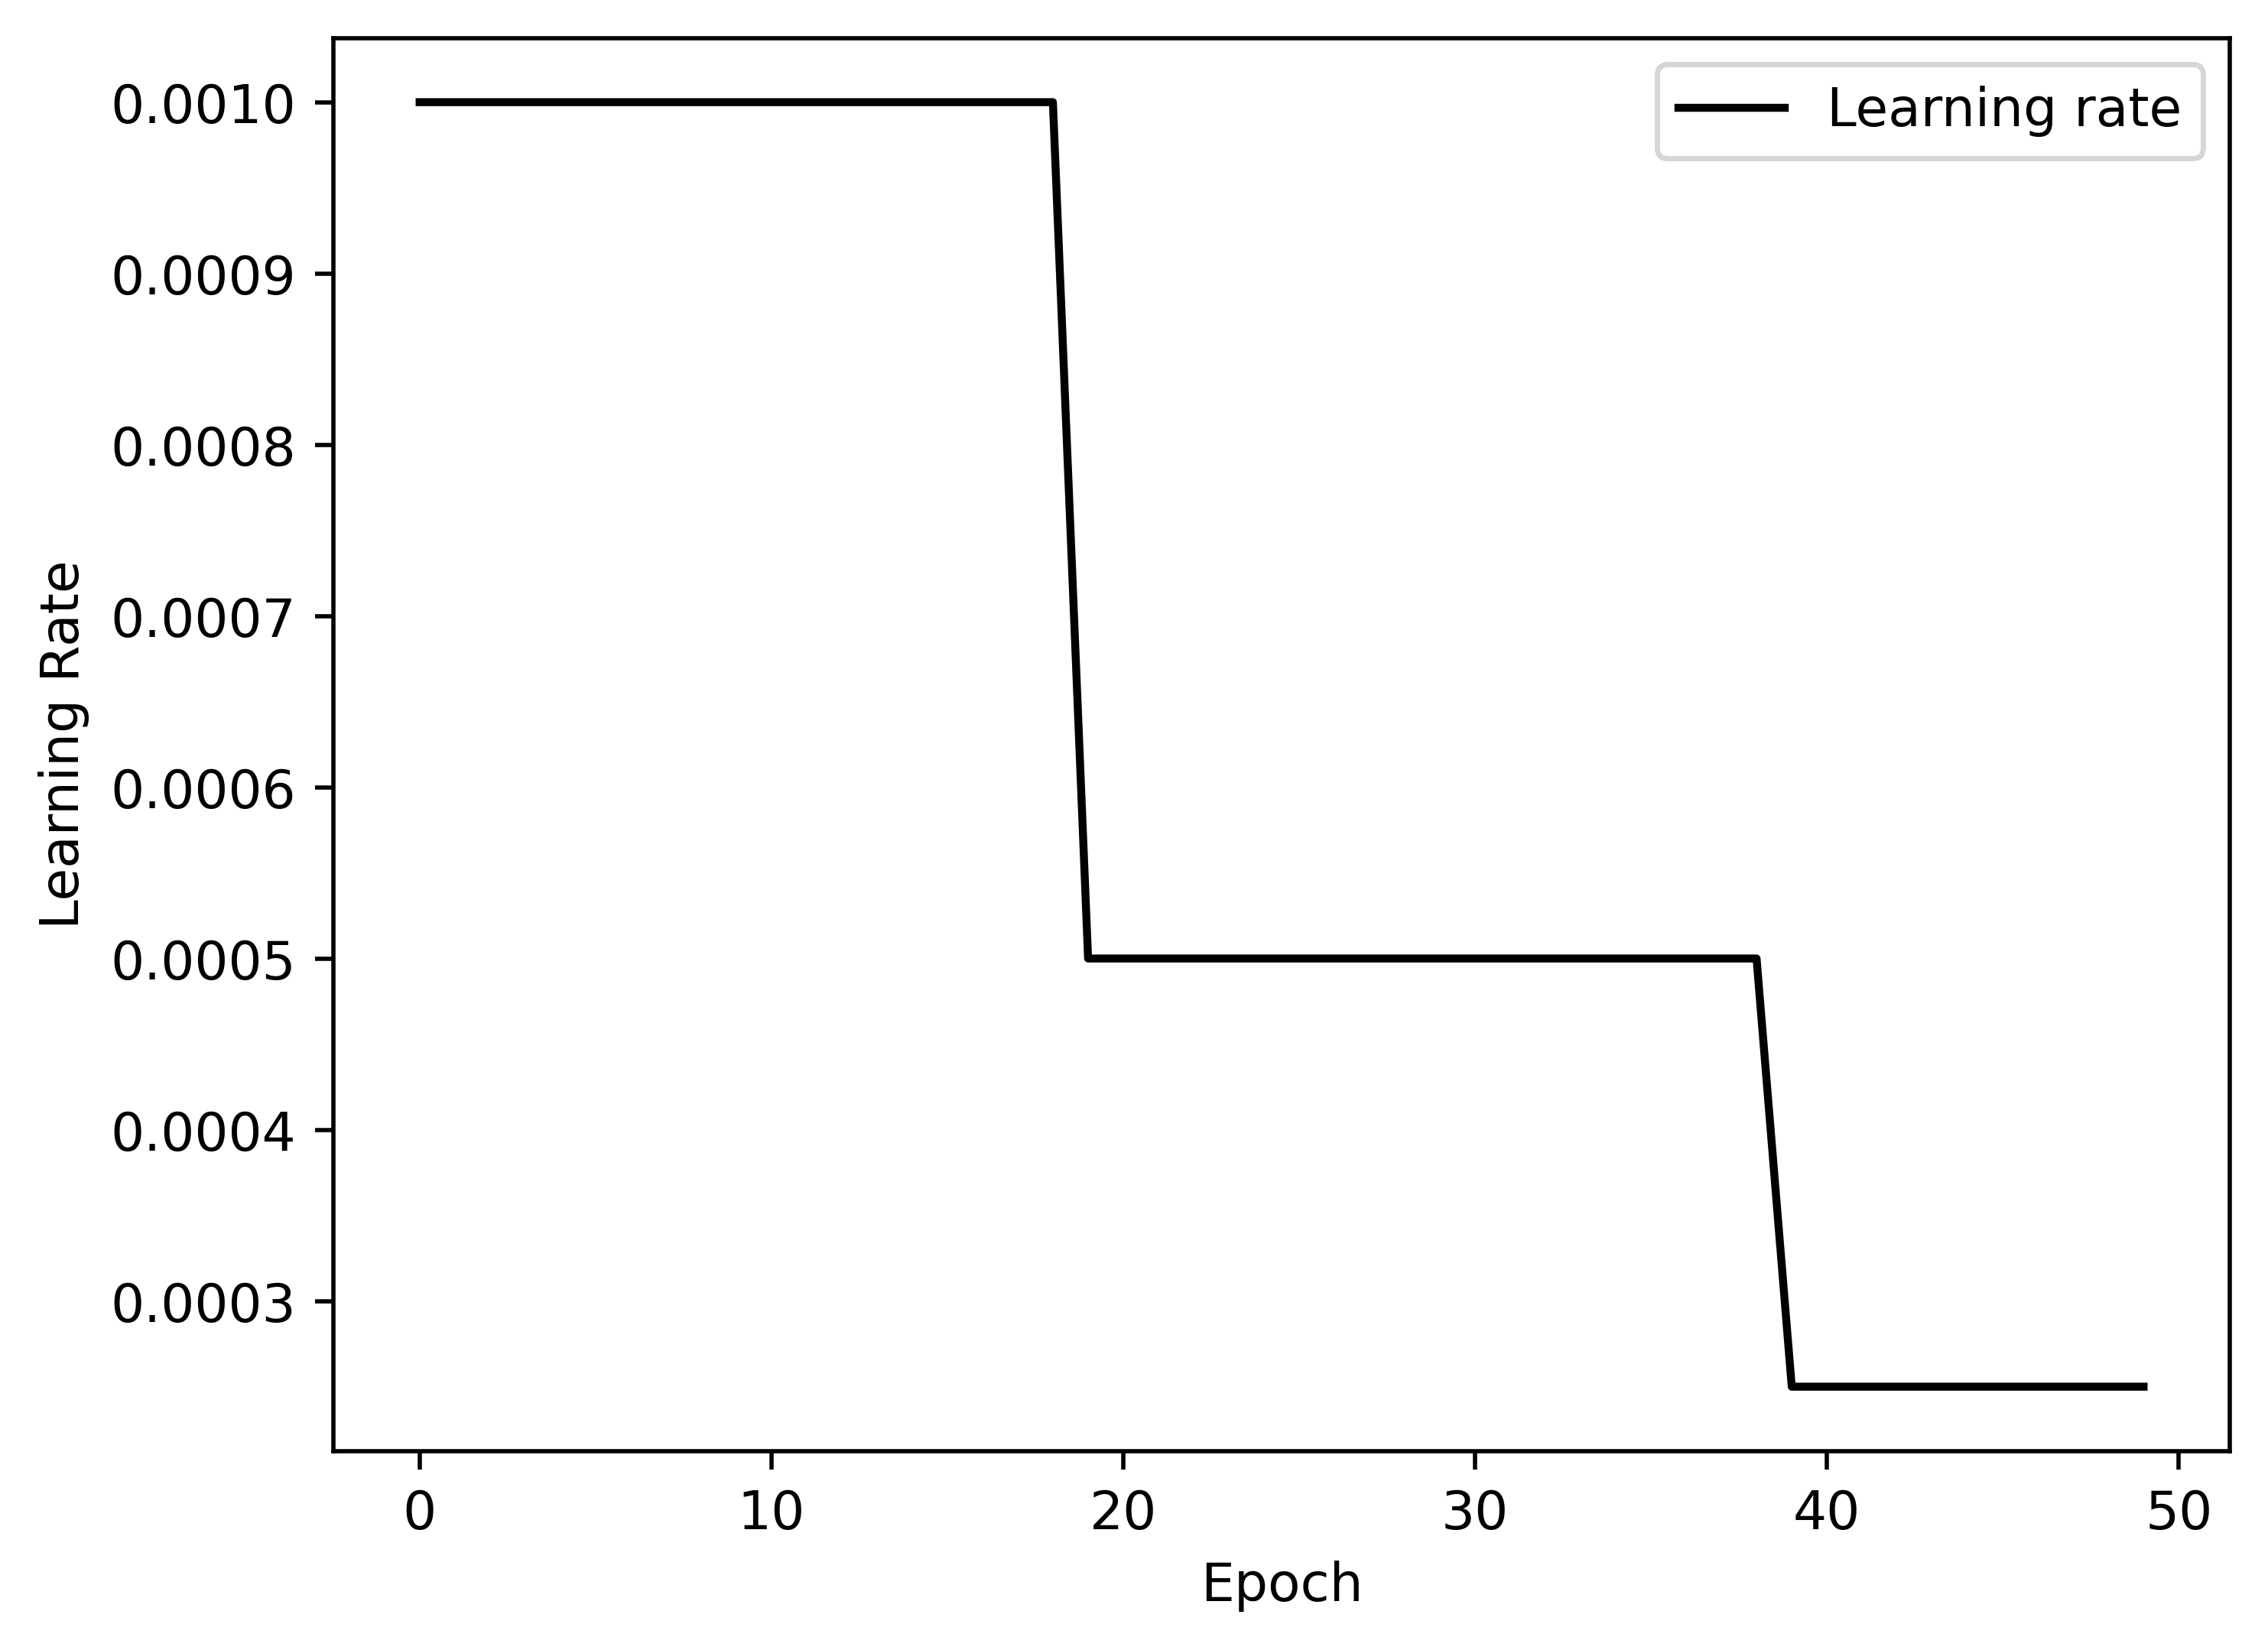

In [31]:
plt.plot(history.history['lr'], label='Learning rate',color = "black")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.legend()
plt.show()

In [32]:
# Evaluating model on Test dataset

model.evaluate(xTest_scaled, yTest)


 1/32 [..............................] - ETA: 1s - loss: 0.1141

32/32 [==============================] - 0s 7ms/step - loss: 0.1124


0.11235439777374268

In [33]:
# Trying to predict shape for
# 1. Test data set
# 2. Train data set
# 1. Test data set
yPredictonTest = model.predict(xTest_scaled)
yPredictonTrain = model.predict(xTrain_scaled)

 1/32 [..............................] - ETA: 0s

484/484 [==============================] - 3s 5ms/step


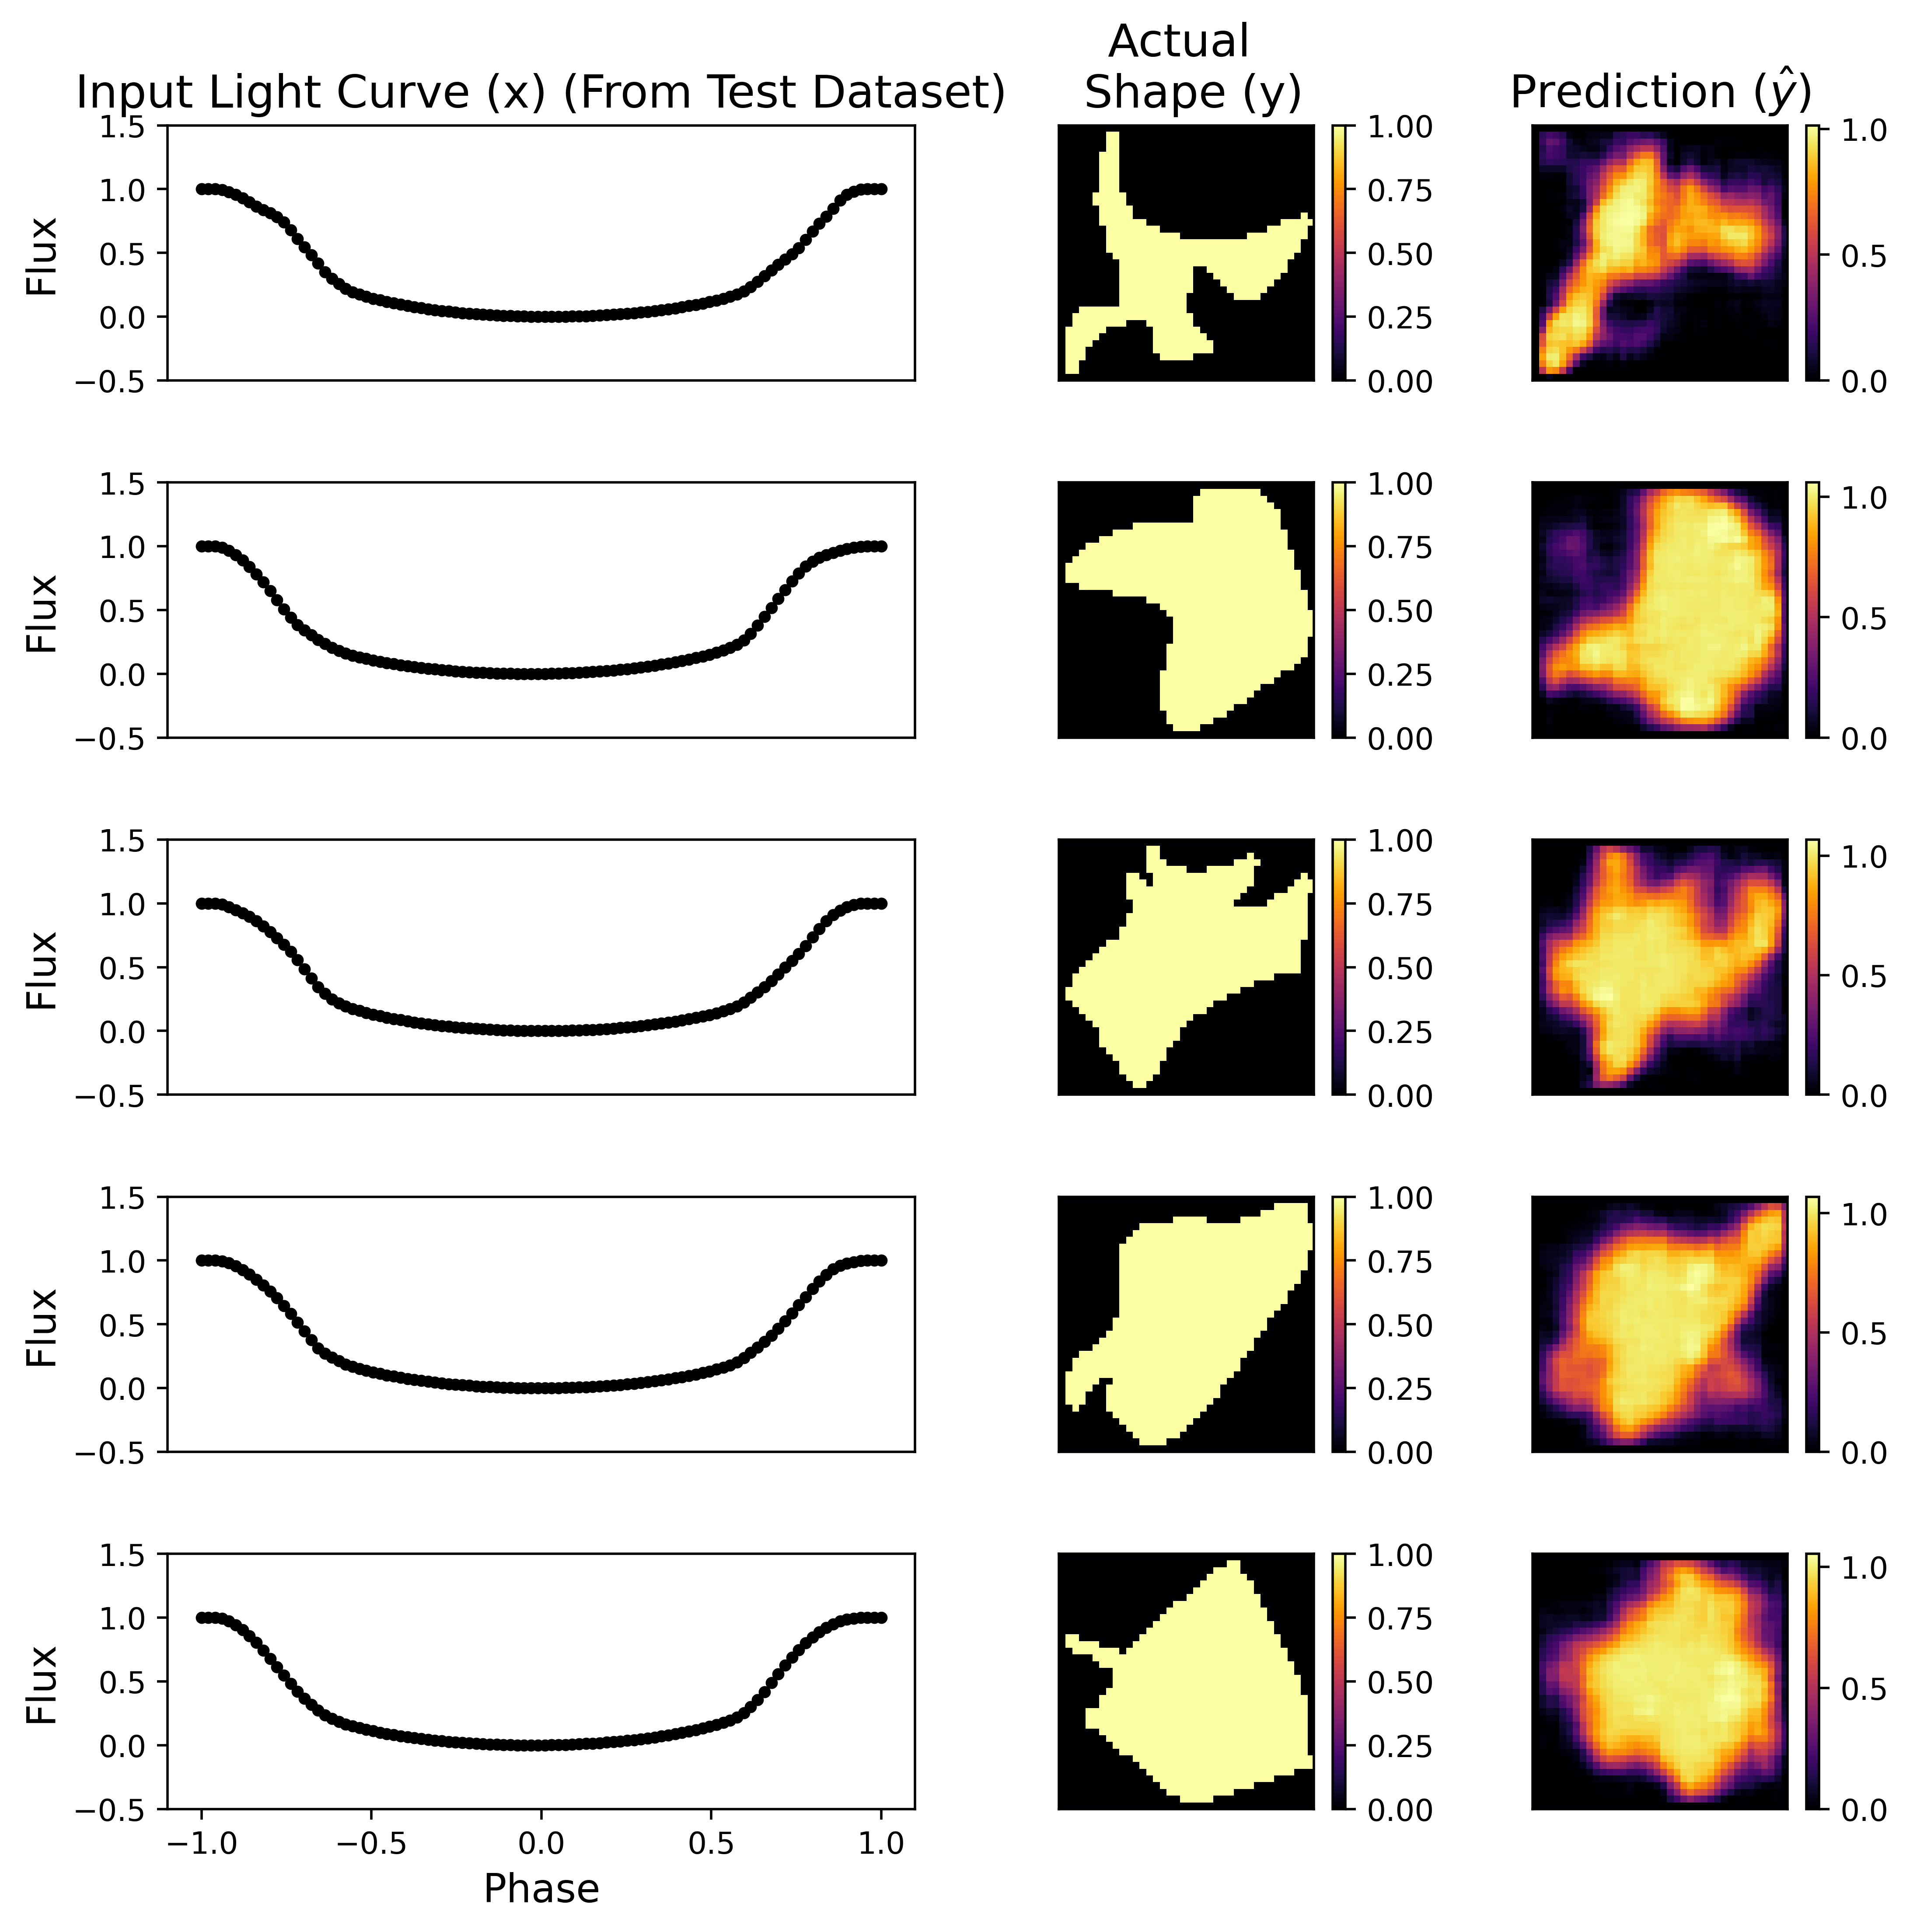

In [35]:
# Test dataset

num = 5
fig,ax=plt.subplots(num,3, figsize=(10,10), gridspec_kw={ 'width_ratios': [2,1,1],
        'wspace': 0.2,'hspace': 0.4})

ax[0][1].set_title('Actual \n Shape (y)',size=15)
ax[0][0].set_title('Input Light Curve (x) (From Test Dataset)',size=15)
ax[0][2].set_title(r'Prediction ($\hat{y}$)',size=15)
ax[num-1][0].set_xlabel('Phase',size=13)
ph = np.linspace(-1.0,1.0,len(xTest[0]))
# advance = 60
for i in range(num):
    k = random.randint(0, len(xTest)-1)
    ax[i][2].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(yTest[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=13)
    ax[i][0].set_ylim(-0.5,1.5)
    ax[i][0].scatter(ph, xTest_scaled[k],color = 'black',marker='.')
    img = ax[i][2].imshow(yPredictonTest[k],cmap='inferno')
    plt.colorbar(img)

In [20]:
yPredicton = model.predict(xTest_scaled)

  1/625 [..............................] - ETA: 17s

625/625 [==============================] - 3s 5ms/step


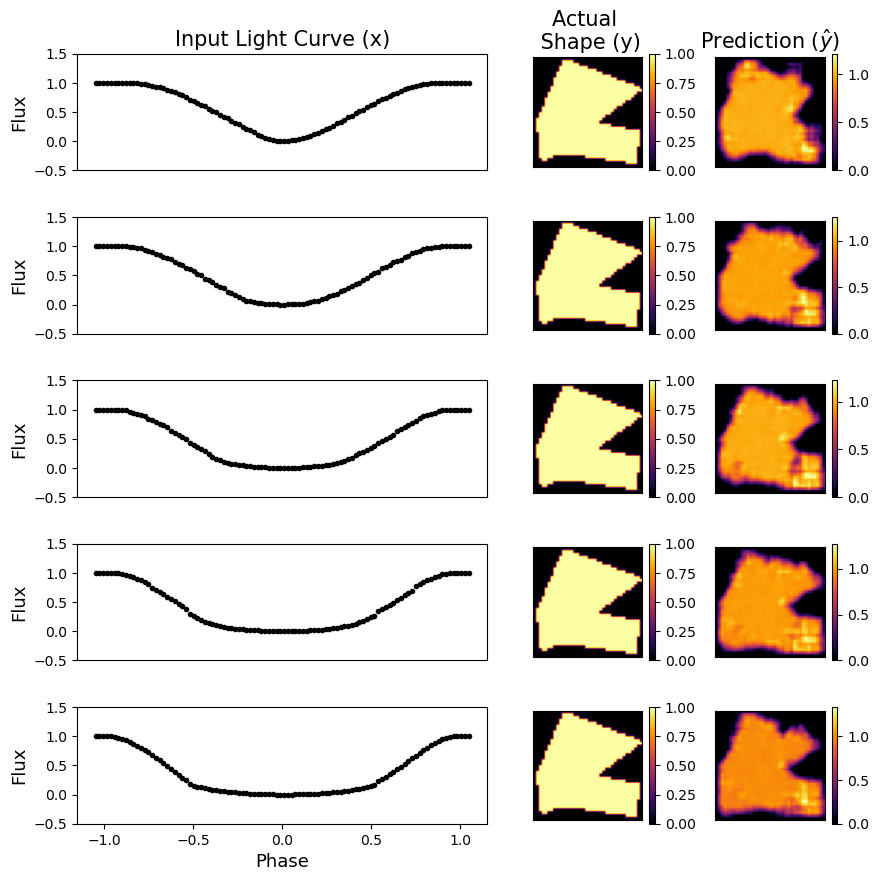

In [21]:
# 0,100,200,300,400

num = 5
fig,ax=plt.subplots(num,3, figsize=(10,10), gridspec_kw={ 'width_ratios': [3,1,1],
        'wspace': 0.2,'hspace': 0.4})

ax[0][1].set_title('Actual \n Shape (y)',size=15)
ax[0][0].set_title('Input Light Curve (x)',size=15)
ax[0][2].set_title(r'Prediction ($\hat{y}$)',size=15)
ax[num-1][0].set_xlabel('Phase',size=13)
ph = np.linspace(-1.0,1.0,len(xTest[0]))
# advance = 60
# num_array = [1,1001,2001,3001,4001]
num_array = [5,1005,2005,3005,4005]
i = 0
for i in np.arange(0,len(num_array)):
    k = num_array[i]
    ax[i][2].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(y_ML[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=13)
    ax[i][0].set_ylim(-0.5,1.5)
    ax[i][0].scatter(ph, x_ML[k],color = 'black',marker='.')
    img = ax[i][2].imshow(yPredicton[k],cmap='inferno')
    plt.colorbar(img)
    i = i + 1

In [25]:
yPredicton[yPredicton>=0.5] = 1.
yPredicton[yPredicton<0.5] = 0.

yPredictonTest[yPredictonTest>=0.5] = 1.
yPredictonTest[yPredictonTest<0.5] = 0.

0.11
0.08
0.07
0.03
0.06


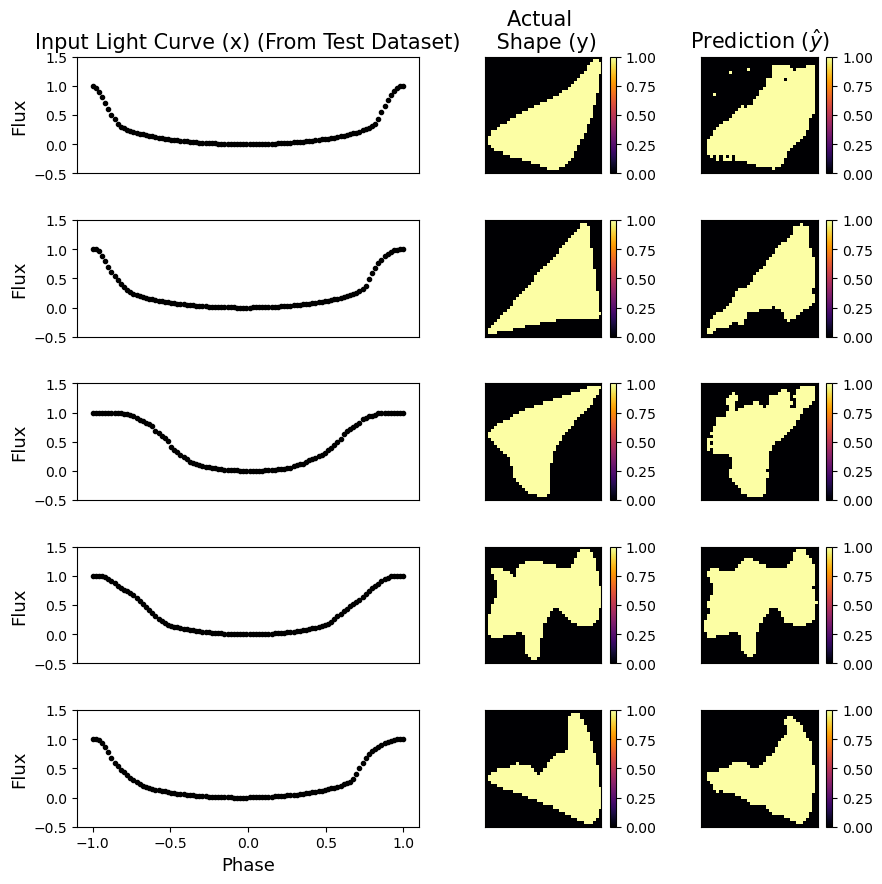

In [30]:
# Test dataset Clipped

num = 5
fig,ax=plt.subplots(num,3, figsize=(10,10), gridspec_kw={ 'width_ratios': [2,1,1],
        'wspace': 0.2,'hspace': 0.4})

ax[0][1].set_title('Actual \n Shape (y)',size=15)
ax[0][0].set_title('Input Light Curve (x) (From Test Dataset)',size=15)
ax[0][2].set_title(r'Prediction ($\hat{y}$)',size=15)
ax[num-1][0].set_xlabel('Phase',size=13)
ph = np.linspace(-1.0,1.0,len(xTest[0]))
# advance = 60
for i in range(num):
    k = random.randint(0, len(xTest)-1)
    ax[i][2].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(yTest[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=13)
    ax[i][0].set_ylim(-0.5,1.5)
    ax[i][0].scatter(ph, xTest[k],color = 'black',marker='.')
    img = ax[i][2].imshow(yPredictonTest[k],cmap='inferno')
    plt.colorbar(img)
    print(round(np.mean(np.abs(yPredictonTest[k] - yTest[k])),2))

0.07
0.02
0.05
0.02
0.06


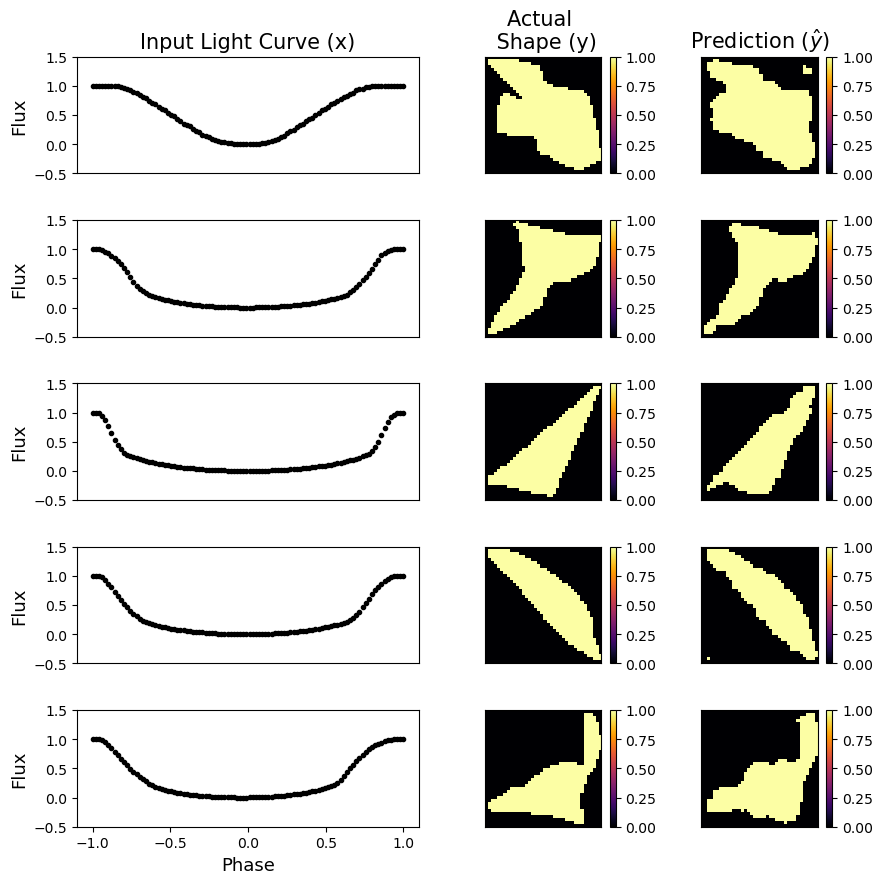

In [36]:

num = 5
fig,ax=plt.subplots(num,3, figsize=(10,10), gridspec_kw={ 'width_ratios': [2,1,1],
        'wspace': 0.2,'hspace': 0.4})

ax[0][1].set_title('Actual \n Shape (y)',size=15)
ax[0][0].set_title('Input Light Curve (x)',size=15)
ax[0][2].set_title(r'Prediction ($\hat{y}$)',size=15)
ax[num-1][0].set_xlabel('Phase',size=13)
ph = np.linspace(-1.0,1.0,len(x_ML[0]))
# advance = 60
for i in range(num):
    k = random.randint(0, len(x_ML)-1)
    ax[i][2].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(y_ML[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=13)
    ax[i][0].set_ylim(-0.5,1.5)
    ax[i][0].scatter(ph, x_ML[k],color = 'black',marker='.')
    img = ax[i][2].imshow(yPredicton[k],cmap='inferno')
    plt.colorbar(img)
    print(round(np.mean(np.abs(yPredicton[k] - y_ML[k])),2))

0.09
0.06
0.06
0.06
0.05


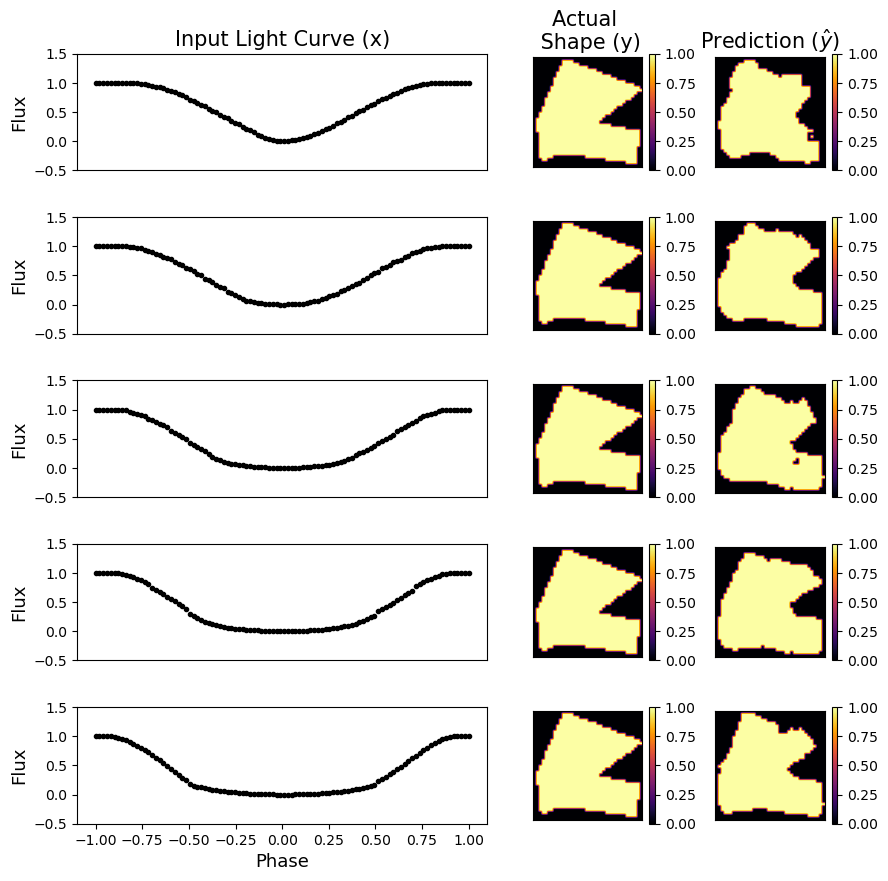

In [38]:
# 0,100,200,300,400

num = 5
fig,ax=plt.subplots(num,3, figsize=(10,10), gridspec_kw={ 'width_ratios': [3,1,1],
        'wspace': 0.2,'hspace': 0.4})

ax[0][1].set_title('Actual \n Shape (y)',size=15)
ax[0][0].set_title('Input Light Curve (x)',size=15)
ax[0][2].set_title(r'Prediction ($\hat{y}$)',size=15)
ax[num-1][0].set_xlabel('Phase',size=13)
ph = np.linspace(-1.0,1.0,len(xTest[0]))
# advance = 60
# num_array = [1,1001,2001,3001,4001]
num_array = [5,1005,2005,3005,4005]
i = 0
for i in np.arange(0,len(num_array)):
    k = num_array[i]
    ax[i][2].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(y_ML[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=13)
    ax[i][0].set_ylim(-0.5,1.5)
    ax[i][0].scatter(ph, x_ML[k],color = 'black',marker='.')
    img = ax[i][2].imshow(yPredicton[k],cmap='inferno')
    plt.colorbar(img)
    i = i + 1
    print(round(np.mean(np.abs(yPredicton[k] - y_ML[k])),2))

In [43]:
model_upload = load_model("/home/abraham/Documents/ml_test/model_aug4_v3_5000epoch_no_noise_normalized_lc.h5")
# summarize model.
model_upload.summary()

Model: "predict_shape_from_LC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 100)]             0         
                                                                 
 reshape_1 (Reshape)         (None, 100, 1)            0         
                                                                 
 batch_normalization (BatchN  (None, 100, 1)           4         
 ormalization)                                                   
                                                                 
 conv16_5 (Conv1D)           (None, 100, 16)           96        
                                                                 
 second_conv16_5 (Conv1D)    (None, 100, 16)           1296      
                                                                 
 maxpool_1 (MaxPooling1D)    (None, 50, 16)            0         
                                             